# 필요한 모듈 import

In [1]:
#pip install holidays

In [2]:
# EDA, 전처리 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
import holidays
import dateutil.easter as easter
sns.set_style('darkgrid')


# 모델링 모듈
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [3]:
# GPU 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-10-26 11:30:20.857066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13799435275426886412
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 30652497920
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 7897109516084344848
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 163053568
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 18307010174728694023
 physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
 xla_global_id: 2144165316]

In [4]:
# GPU 사용가능 확인
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# EDA

### 범주형 변수들(Categorical variables)

In [5]:
print(os.getcwd())

/home/centos/lkm/TabularPlaygroundSeries_Sep2022


In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 나중을 위해 train의 복사본 저장
original_train_df = train.copy()

In [7]:
display(train.head())
display(test.head())

row_id        date  country       store                           product  \
0       0  2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1  2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2  2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3  2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4  2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id        date  country       store                           product
0   70128  2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129  2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130  2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131  2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132  2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [8]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB


None

**데이터 관측 결과:**  
- 3개의 범주형 column이 합쳐져서 단변량 시계열 데이터(univariate time series)를 이루고 있음
- 이외에도 country, store, product도 범주형 데이터에 해당함

In [9]:
# date column을 시계열 데이터로 쓰기 위해 datetime으로 타입 변경
train['date'] = train['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')

In [10]:
# 타입 변경 확인
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   row_id   17520 non-null  int64         
 1   date     17520 non-null  datetime64[ns]
 2   country  17520 non-null  object        
 3   store    17520 non-null  object        
 4   product  17520 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 684.5+ KB


None

In [11]:
# 개수를 세서 pie-chart를 출력하게끔 만드는 함수 정의
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(
        columns={column_name:"Value Count", "index":column_name}).set_index(
        column_name)
    value_count['Percentage'] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), 
                                             legend=False, ylabel="");

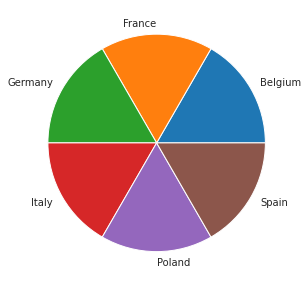

In [12]:
plot_and_display_valuecounts(train, "country")

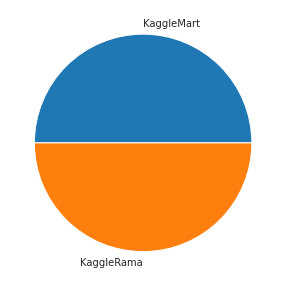

In [13]:
plot_and_display_valuecounts(train, "store")

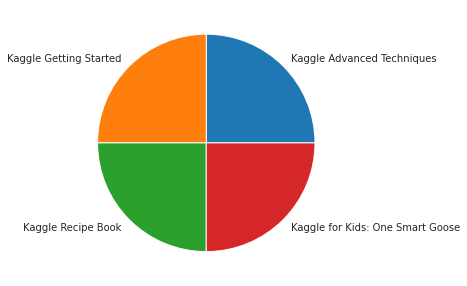

In [14]:
plot_and_display_valuecounts(train, "product")

**Pie-chart 해석:**  
- 모든 그룹이 동등하게 데이터를 가지고 있는 것으로 관측됨
- 하지만 모든 국가가 모든 가게를 가지고 있고, 모든 가게마다 모든 제품들을 팔고 있는지를 좀더 확실하게 살펴보기로 함

<Figure size 1080x432 with 0 Axes>

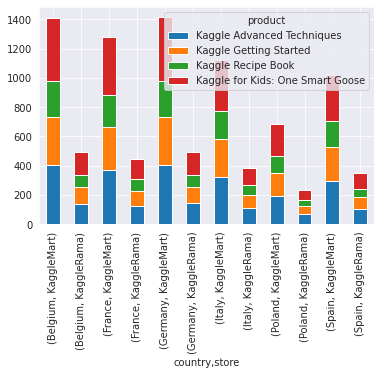

In [15]:
# groupby를 활용하여 데이터의 분포를 파악
plt.figure(figsize=(15, 6))
train.groupby(['country', 'store', 'product'])['num_sold'].mean().unstack().plot(kind='bar', stacked=True)
plt.show()

위 결과를 보면 모든 국가에 모든 가게가 존재하며, 모든 가게에서 모든 제품을 보유하고 있음을 알 수 있음  
단, 가게별 판매량은 모든 국가에서 **KaggleMart가 KaggleRama보다 더 많은 양상**을 띠고 있음

### 시계열 데이터(Time series)

In [16]:
# train과 test의 시계열 데이터의 시작과 끝 확인
print("가장 오래된 날짜:", train["date"].min())
print("가장 최근의 날짜:", train["date"].max())

print("가장 오래된 날짜:", test["date"].min())
print("가장 최근의 날짜:", test["date"].max())

가장 오래된 날짜: 2017-01-01 00:00:00
가장 최근의 날짜: 2020-12-31 00:00:00
가장 오래된 날짜: 2021-01-01 00:00:00
가장 최근의 날짜: 2021-12-31 00:00:00


- 현재 **2017-01-01부터 2020-12-31까지의 4년치 학습 데이터**가 존재함
- 이를 바탕으로 **2021-01-01부터 2021-12-31까지의 1년치 데이터**를 예측해야 함

In [17]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [18]:
# 주간, 월간 데이터의 동향을 살펴보기 위해 주간, 월간 데이터프레임을 새로 정의
# date column의 타입을 datetime으로 하지 않으면 이 코드 실행 시 오류남!
weekly_df = train.groupby(['country', 'store', 'product', 
                           pd.Grouper(key='date', freq='W')])['num_sold'].sum().rename("num_sold").reset_index()
monthly_df = train.groupby(['country', 'store', 'product', 
                            pd.Grouper(key='date', freq='MS')])['num_sold'].sum().rename("num_sold").reset_index()

In [19]:
# 선그래프를 그려주는 함수 정의
def plot_all(df):
    f,axes = plt.subplots(2,2,figsize=(20,15), sharex=True, sharey=True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data=plot_df, x='date', y='num_sold', hue='country', 
                     style='store', ax=axes[n//2, n%2])
        axes[n//2, n%2].set_title("Product: " + str(prod))

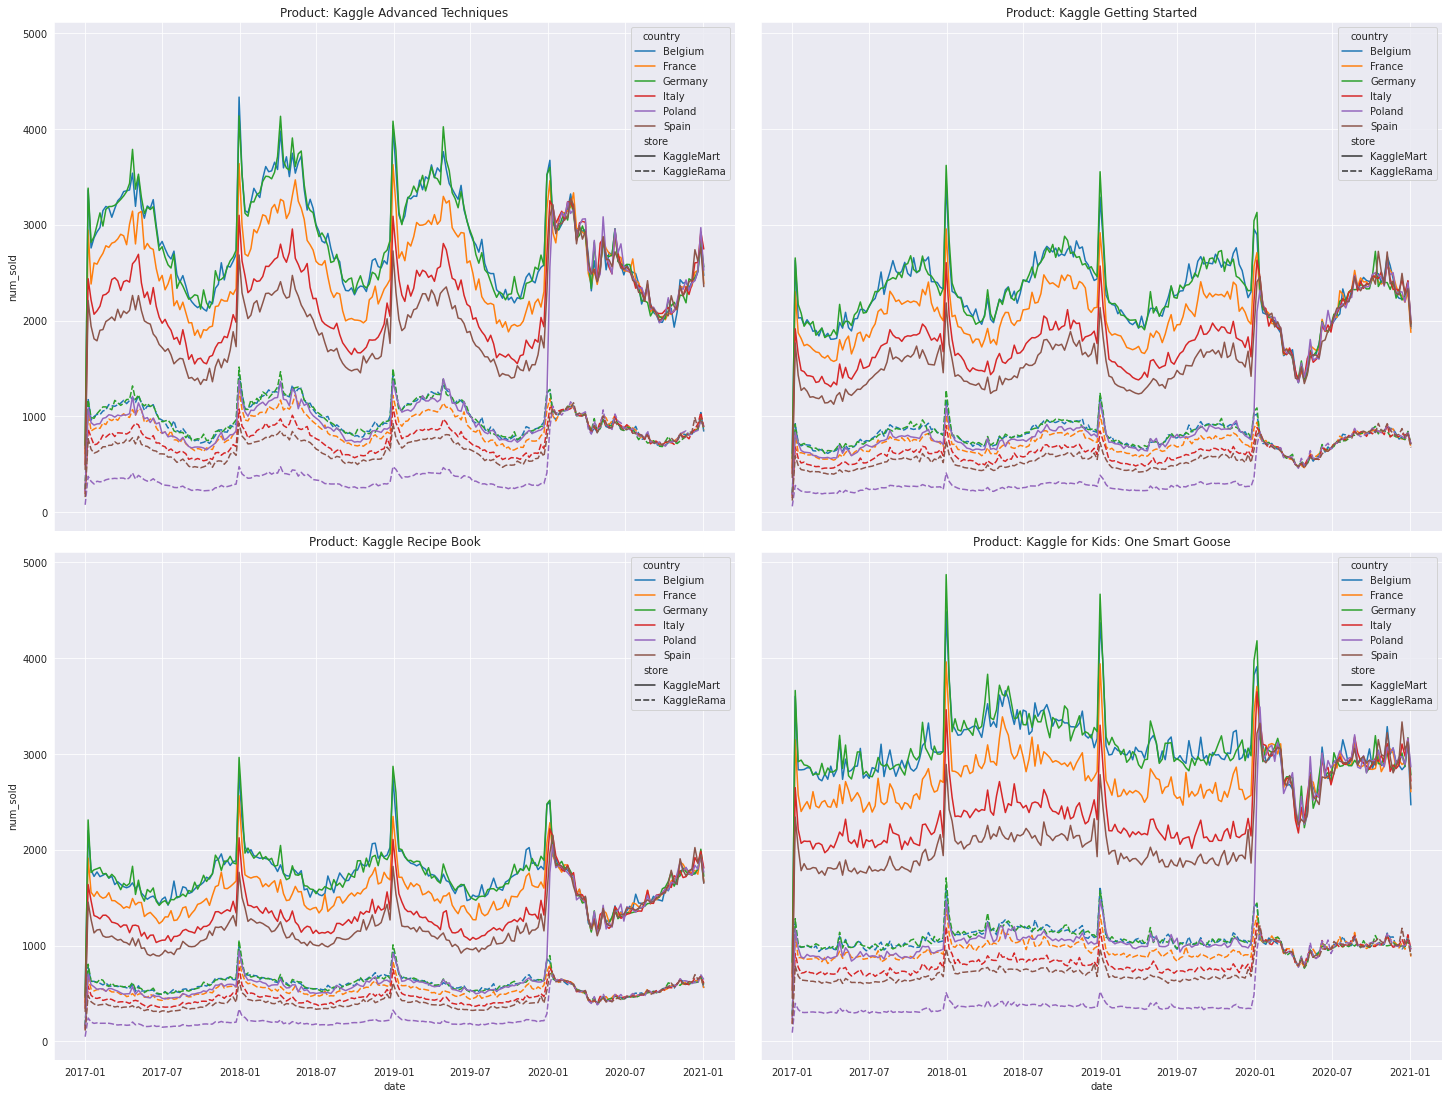

In [20]:
# 주간 데이터 시각화
plot_all(weekly_df)

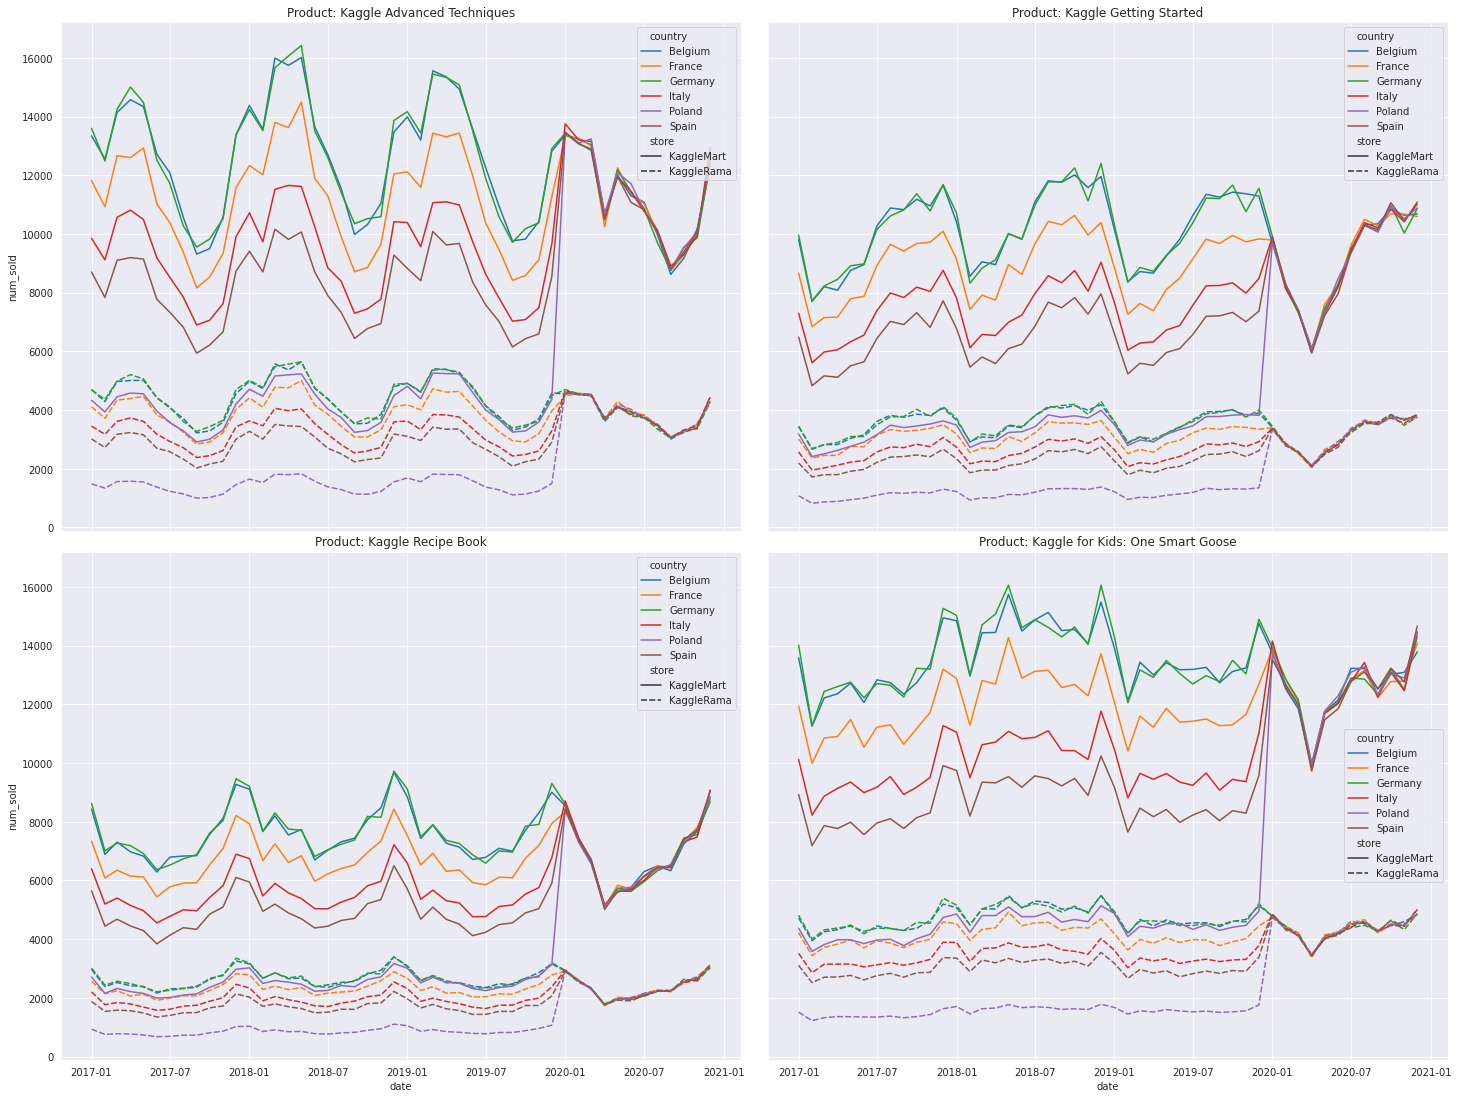

In [21]:
# 월간 데이터 시각화
plot_all(monthly_df)

**Line-graph 해석:**  
- 2020년은 다른 연도와 눈에 띄게 다른 것을 포착할 수 있었음. 판매량이 국가 간에 거의 차이가 없는 것으로 나타남
- 각각의 제품들은 서로 다른 판매량의 패턴을 보임
- 두 가게 간의 패턴은 굉장히 유사함. KaggleMart와 KaggleRama가 비슷한 패턴을 보이되, 모든 곳에서 KaggleMart의 판매량이 더 많은 패턴을 보임
- 비슷하게 각 국가 간의 패턴도 굉장히 유사함. 국가 간에 판매량의 차이만 있을뿐 그래프의 경향선은 굉장히 비슷한 패턴을 보임

## 시계열 데이터 집계(Aggregating Time Series)

지금까지의 **EDA**를 통해 범주형 변수들(country, store, product)의 시계열 데이터들을 집계하는 것이 좋은 아이디어라는 것을 보여주어야 함

### (1) store

<u>country와 product와는 상관없이</u> store간의 패턴이 동일한지 테스트해보기로 함

In [22]:
# 가게의 비율 파악
store_weights = train.groupby('store')['num_sold'].sum()/train['num_sold'].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [23]:
# 각 제품에 존재하는 가게의 비율 파악
product_store_weights = monthly_df.groupby(['product', 'store'])['num_sold'].sum()/monthly_df.groupby(['product'])['num_sold'].sum()
product_store_weights

# 아래 코드를 실행하면 날짜까지 더 세부적으로 비율을 파악할 수 있음
#monthly_df.groupby(["product","store", "date"])["num_sold"].sum() / monthly_df.groupby(["product","date"])["num_sold"].sum()

product                           store     
Kaggle Advanced Techniques        KaggleMart    0.742447
                                  KaggleRama    0.257553
Kaggle Getting Started            KaggleMart    0.742500
                                  KaggleRama    0.257500
Kaggle Recipe Book                KaggleMart    0.742765
                                  KaggleRama    0.257235
Kaggle for Kids: One Smart Goose  KaggleMart    0.742450
                                  KaggleRama    0.257550
Name: num_sold, dtype: float64

<해석>  
- KaggleMart가 꾸준히 약 74.25%의 판매량을 보유하고 있는 것을 관측할 수 있음
- KaggleRama의 판매량에 **어떤 상수를 곱하여** KaggleMart의 판매량과 비슷하게 맞춘 뒤, 그래프를 그렸을 때 *두 가게의 그래프가 거의 완벽하게 겹치면* **트렌드**나 **계절성**이 가게의 영향을 받는다고 보기는 어렵기 때문에 **가게의 영향을 무시할 수 있음!**

In [24]:
# 가게에 따른 판매량의 경향을 그래프로 나타내기 위한 함수 정의
def plot_adjusted_store(df):
    new_df = df.copy()
    # 위 해석에서 언급한 상수가 바로 weights에 해당
    weights = (product_store_weights.reset_index().groupby(
        'store')['num_sold'].mean().loc["KaggleMart"] / 
        product_store_weights.reset_index().groupby(
        'store')['num_sold'].mean())
    for store in weights.index:
        new_df.loc[new_df['store'] == store, 'num_sold'] = new_df.loc[new_df['store'] == store, 'num_sold'] * weights[store]
        plot_all(new_df)

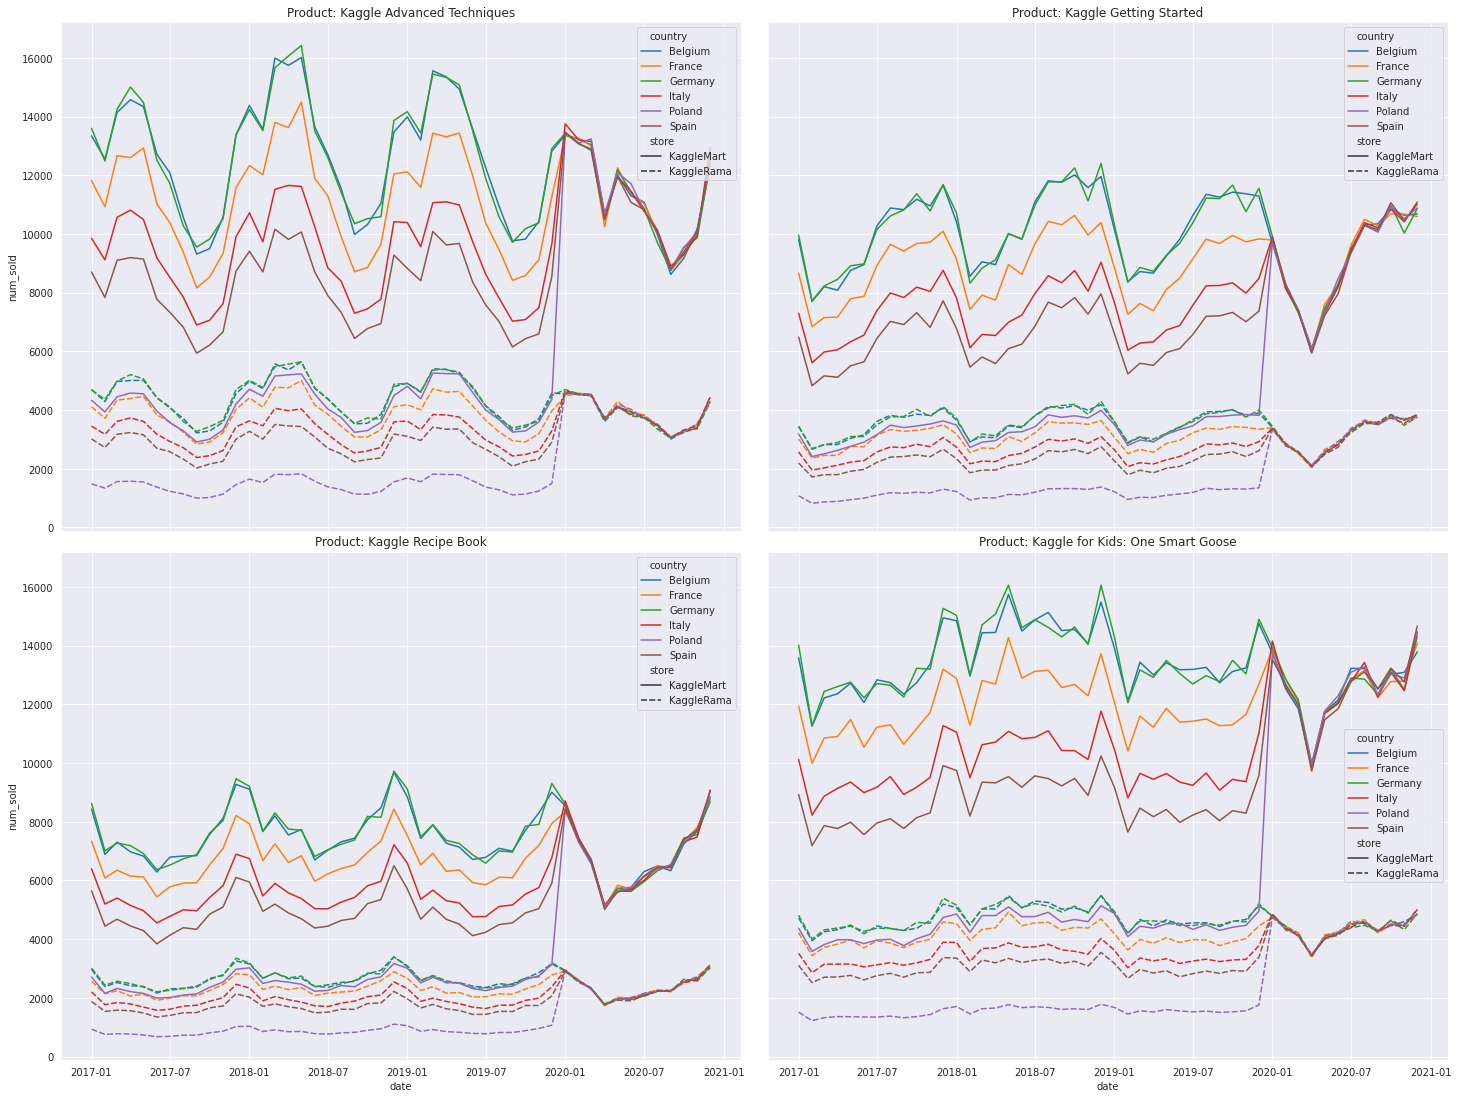

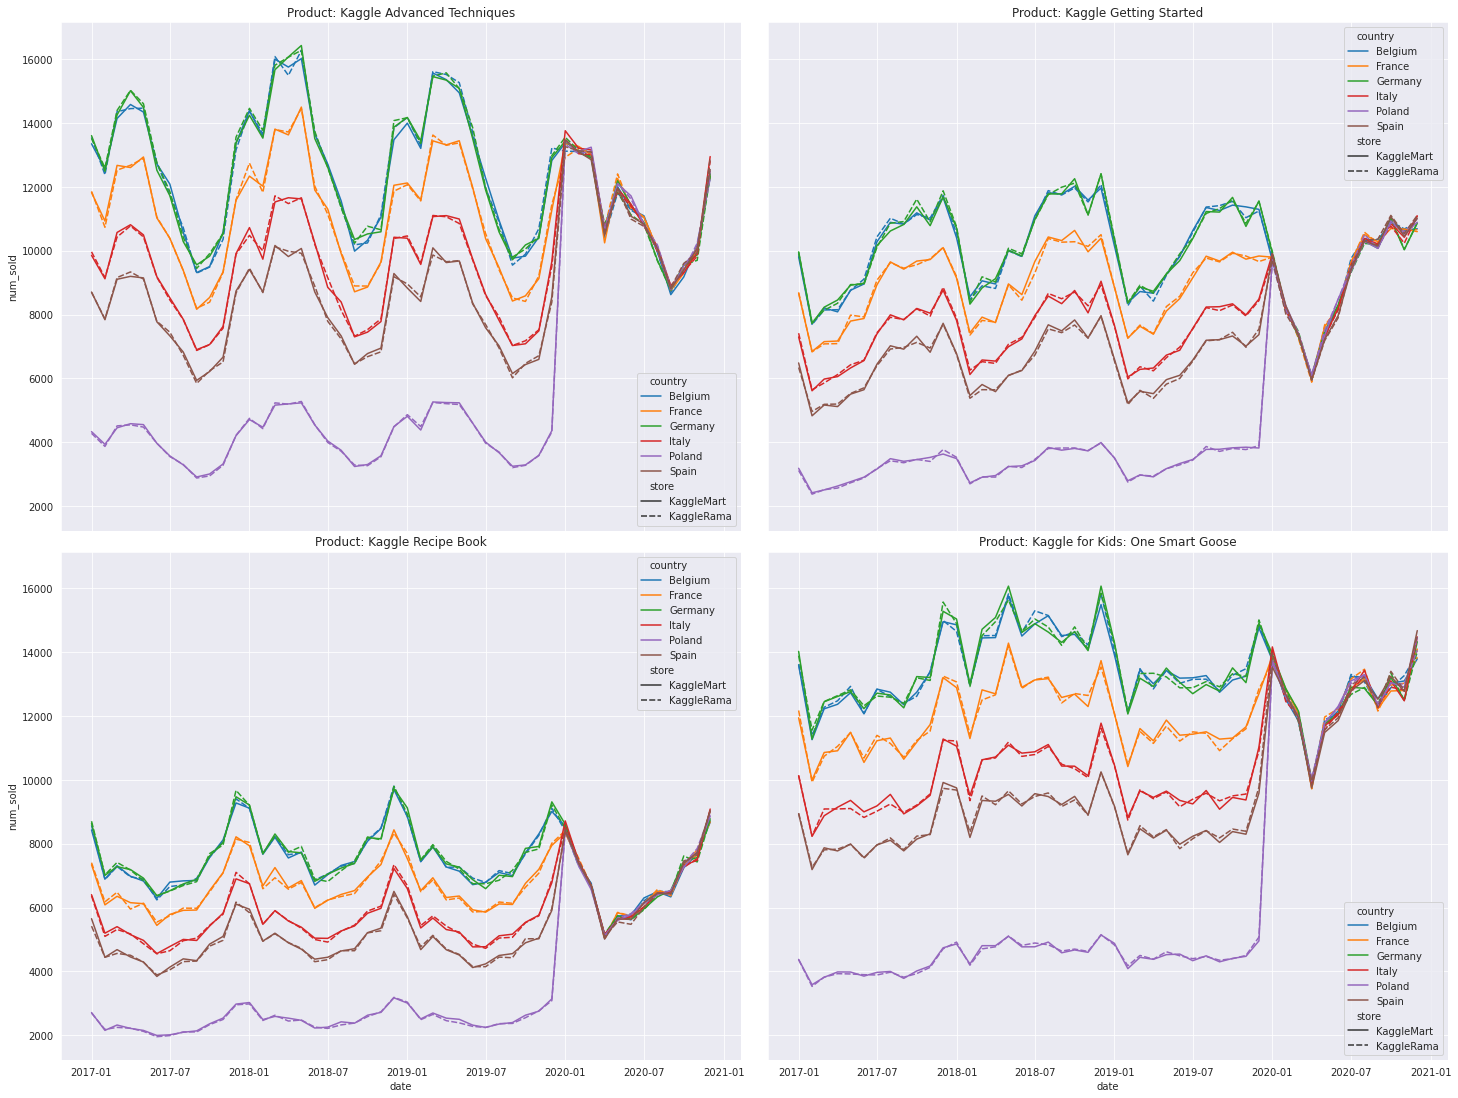

In [25]:
# 월간 데이터 시각화
plot_adjusted_store(monthly_df)

# 주간 데이터 시각화
#plot_adjusted_store(weekly_df)

**관측 결과:**  
- 먼저 나타난 4개의 그래프에서 실선과 점선으로 구분했던 두 가게의 그래프가 아래 4개의 그래프에서는 거의 완벽하게 겹치고 있음을 확인할 수 있음  

**Insights:**  
- y축에 있는 값에 집중할 필요 없음, 아무 의미가 없음. 그래프를 그린 목적은 어디까지나 두 실선과 점선 그래프가 겹치는지를 확인하기 위함이었음
- **트렌드와 계절성**이 가게의 영향을 받는다고 보기 어려우므로 **가게의 영향을 무시할 수 있음!** 판매량의 차이들은 시간과 상관없이 단일 상수(single constant)로 설명이 가능함
- 이는 즉 가게 집계 시계열 데이터(store aggregated time series)를 예측한 다음, 과거 비율(historical proportions)을 기반으로 예측을 세분화할 수 있음을 의미함

### (2) country

**2020년 이전** 데이터들의 국가 간 차이도 **단일 상수(single constant)로 설명 가능한지** 확인해보기로 함

In [26]:
# 각 제품에 존재하는 국가의 비율 파악
new_monthly_df = monthly_df.loc[monthly_df['date'] < '2020-01-01']

product_country_weights = new_monthly_df.groupby(
    ['product', 'country'])['num_sold'].sum() / new_monthly_df.groupby(
    ['product'])['num_sold'].sum()
product_country_weights

product                           country
Kaggle Advanced Techniques        Belgium    0.218832
                                  France     0.191456
                                  Germany    0.219423
                                  Italy      0.159464
                                  Poland     0.071352
                                  Spain      0.139474
Kaggle Getting Started            Belgium    0.219094
                                  France     0.191188
                                  Germany    0.219410
                                  Italy      0.159473
                                  Poland     0.071316
                                  Spain      0.139518
Kaggle Recipe Book                Belgium    0.219069
                                  France     0.191101
                                  Germany    0.219778
                                  Italy      0.159175
                                  Poland     0.071355
                                  Spain 

In [27]:
# 국가의 비율 파악
country_weights = train.groupby('country')['num_sold'].sum()/train['num_sold'].sum()
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: num_sold, dtype: float64

In [28]:
# Belgium을 기준으로 각 국가의 상대적 비율을 계산
(product_country_weights.reset_index().groupby('country')['num_sold'].mean() / 
product_country_weights.reset_index().groupby('country')['num_sold'].mean().loc['Belgium'])

country
Belgium    1.000000
France     0.873799
Germany    1.002921
Italy      0.727856
Poland     0.325852
Spain      0.636735
Name: num_sold, dtype: float64

In [29]:
# 각 국가가 Belgium과 겹쳐지려면 증가해야 하는 상대적 비율을 계산
(product_country_weights.reset_index().groupby('country')['num_sold'].mean().loc['Belgium'] / 
product_country_weights.reset_index().groupby('country')['num_sold'].mean())

country
Belgium    1.000000
France     1.144428
Germany    0.997088
Italy      1.373899
Poland     3.068876
Spain      1.570512
Name: num_sold, dtype: float64

In [30]:
# 국가에 따른 판매량의 경향을 그래프로 나타내기 위한 함수 정의
def plot_adjust_country(df):
    new_df = df.copy()
    # weights에 위에서 구한 Belgium을 기준으로 둔 비율을 넣음
    weights = product_country_weights.reset_index().groupby('country')['num_sold'].mean().loc['Belgium'] / product_country_weights.reset_index().groupby('country')['num_sold'].mean()
    
    for country in weights.index:
        new_df.loc[(new_df['country'] == country) & (new_df['date'] < '2020-01-01'), 'num_sold'] = new_df.loc[(new_df['country'] == country) & (new_df['date'] < '2020-01-01'), 'num_sold'] * weights[country]
    plot_all(new_df)

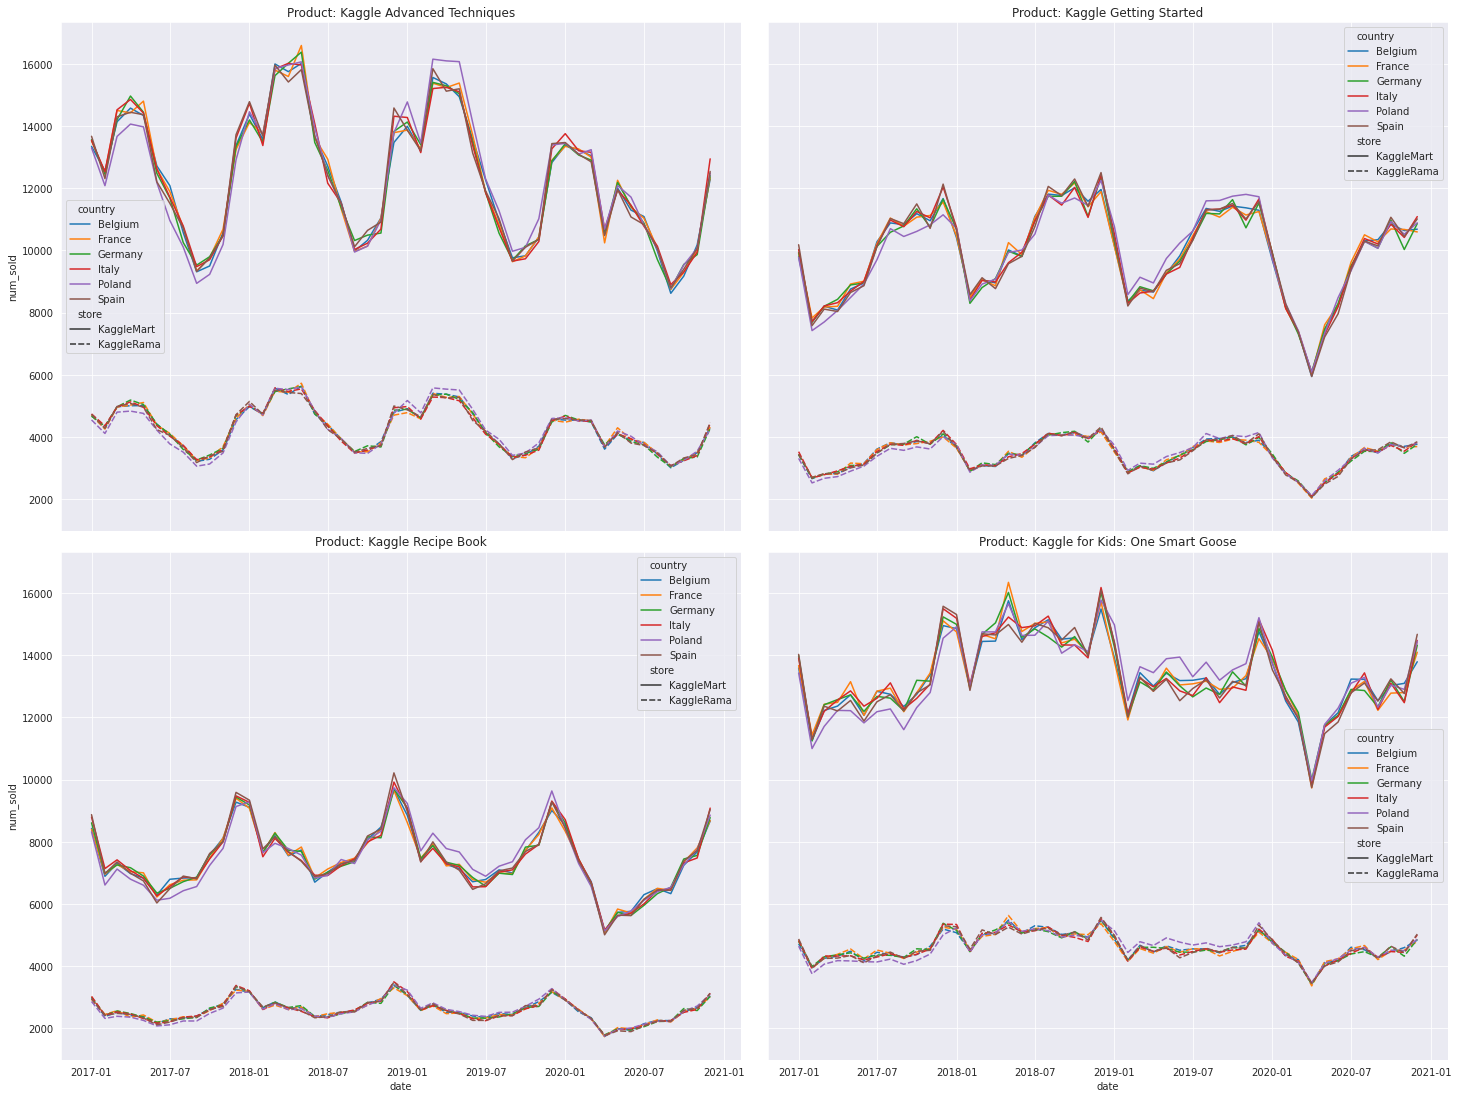

In [31]:
plot_adjust_country(monthly_df)

**관측 결과:**  
- Poland의 그래프는 조금씩 겹치지 않고 엇나간 부분이 있지만, 그래도 이것도 상당히 그래프가 잘 겹치는 것을 확인할 수 있음
- 이것 역시 앞서 상점 데이터와 동일하게 국가 집계 시계열 데이터(country aggregated time series)를 예측한 다음, 과거 비율을 기반으로 예측을 세분화할 수 있음을 의미함
- 앞서 2020년은 혼자서 경향이 다르기 때문에, 일단 2020년 데이터는 제외하고 분석했음을 기억

### (3) country and store

지금까지 country와 store에 했던 것을 동시에 시도해보기로 함  

그래프를 통해 어떤 상수(a constant)를 곱하면 모든 시계열 데이터를 Belgium KaggleMart의 선과 동일하게 겹쳐지도록 시도

In [32]:
def plot_adjust_country_store(df):
    new_df = df.copy()
    
    store_weights = product_store_weights.reset_index().groupby("store")["num_sold"].mean().loc["KaggleMart"] / product_store_weights.reset_index().groupby("store")["num_sold"].mean()
    country_weights = product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] / product_country_weights.reset_index().groupby("country")["num_sold"].mean()
    
    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  country_weights[country]
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    plot_all(new_df)

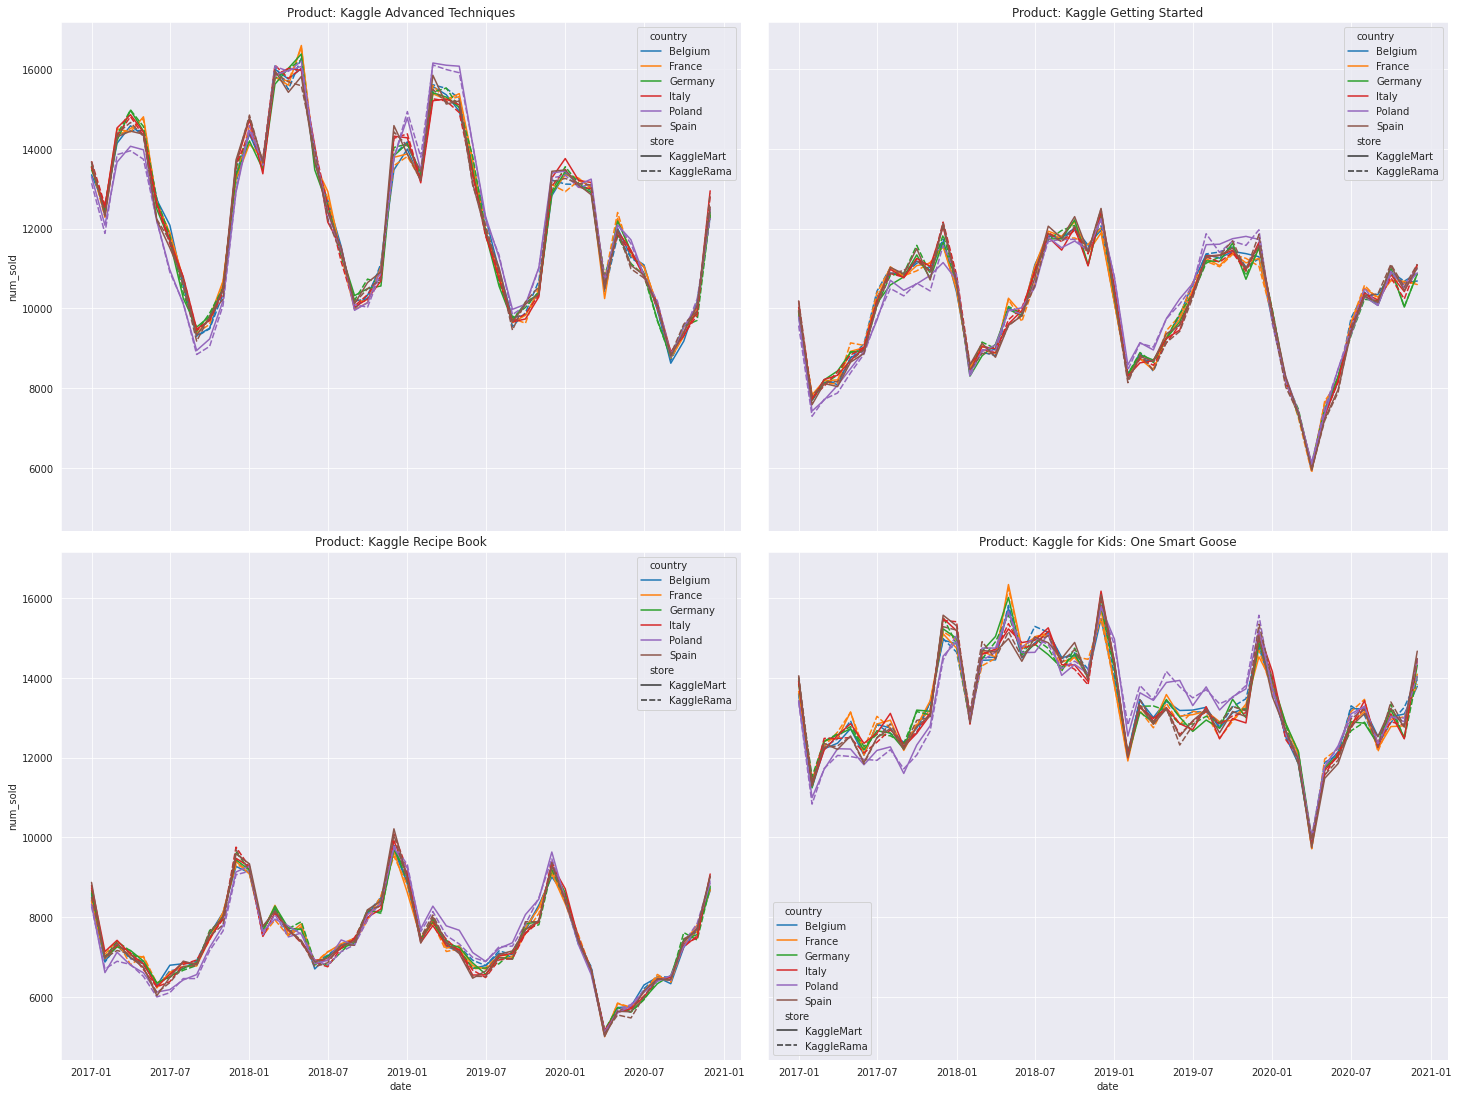

In [33]:
plot_adjust_country_store(monthly_df)

**관측 결과:**  
- 100% 완벽하진 않지만(특히 Poland의 경우에는), 그래도 상당히 하나의 경향으로 잘 겹쳐질 수 있음을 확인할 수 있었음  

**Insights:**  
- 우선 예측을 위해서 가게들의 데이터를 집계한 뒤, 이후 각 가게의 실제 예측값을 얻기 위해 과거의 순판매량의 비율을 사용할 수 있을 것으로 보임
- 국가 데이터의 경우 2020년만이 조금 다르기 때문에 모든 국가에 동일한 판매량의 비율을 주거나, 그냥 2020년은 예외(exception)라고 생각하여 2020년 이전까지 계산했던 비율을 가지고 추후 예측을 수행해도 될 것 같음

### (4) product

product는 조금 다른 접근이 필요함

In [34]:
product_df = train.groupby(['date', 'product'])['num_sold'].sum().reset_index()
product_df.head()

date                           product  num_sold
0 2017-01-01        Kaggle Advanced Techniques      4267
1 2017-01-01            Kaggle Getting Started      3492
2 2017-01-01                Kaggle Recipe Book      2900
3 2017-01-01  Kaggle for Kids: One Smart Goose      4693
4 2017-01-02        Kaggle Advanced Techniques      3242

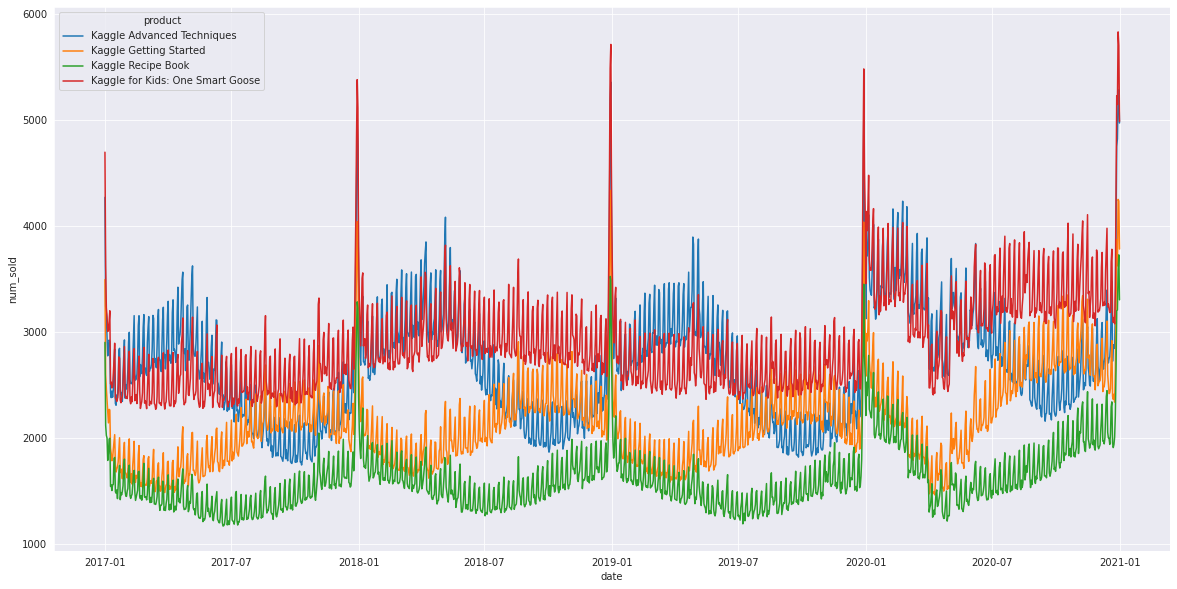

In [35]:
# 제품들의 경향 그래프로 확인
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x='date', y='num_sold', hue='product');

**각 날짜별 제품 판매 비율(Product ratio for each date)**

In [36]:
product_ratio_df = product_df.pivot(index='date', columns='product', values='num_sold')
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(), axis=1)
product_ratio_df = product_ratio_df.stack().rename('ratios').reset_index()
product_ratio_df.head()

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693
4 2017-01-02        Kaggle Advanced Techniques  0.280014

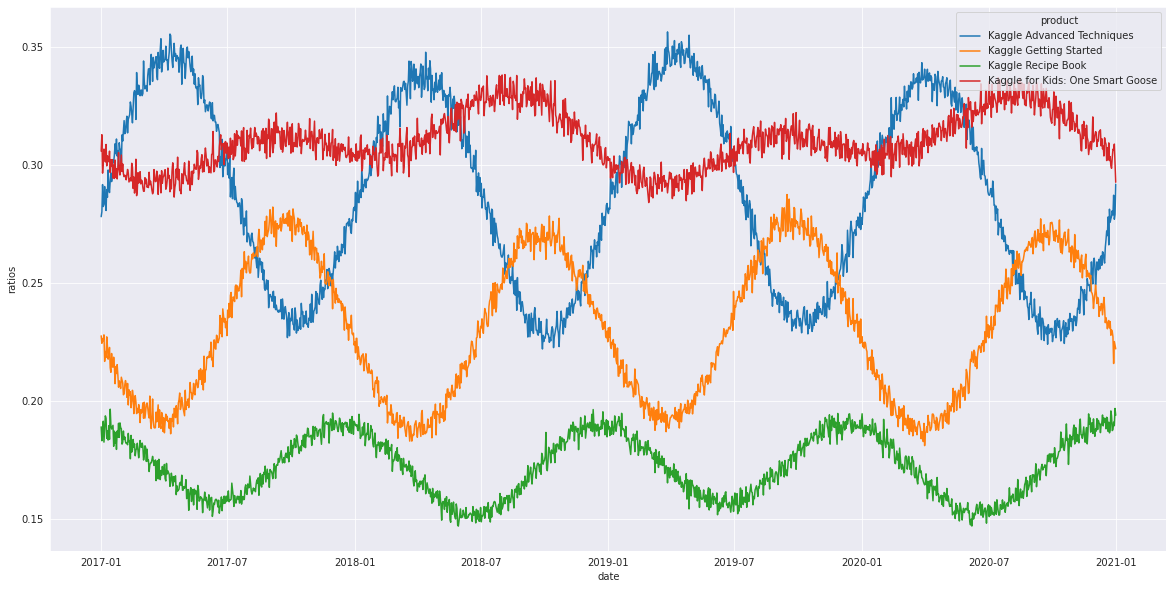

In [37]:
# 각 날짜별 제품 판매 비율의 경향 그래프로 확인
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_ratio_df, x='date', y='ratios', hue='product');

**관측 결과:**  
제품 판매 비율 그래프는 시간에 따라 각 제품이 약 2년 주기로 사인(Sine) 곡선을 그리며 변화하고 있음을 알 수 있음  

**Insight:**
- 각 제품별 판매 비율 그래프가 명확하게 계절마다 반복되는 패턴을 띄고 있기 때문에, 각 제품을 독립적으로 예측할 필요가 없음(or 제품을 범주형 변수로 취급할 필요가 없음)
- 대신 각 날짜마다의 판매 총액을 예측한 뒤, 각 날짜별 예측 비율을 토대로 예측 판매 총액을 각 제품별 예측 판매액으로 변환하는 쪽으로 분석을 진행해야 함  

**<결론>**  
최종적으로 딱 2개의 시계열 데이터만 예측하면 됨:  
1. 각 날짜별 판매 총액(The total sales each day)
2. 각 날짜의 제품별 판매 비율(The ratio in number of sales for each product each day)  
일단 예측을 완료하면 예측을 3가지 범주형 변수로 쪼갤 수 있음: **product, country, 그리고 store**

## 집계된 시계열 데이터(Aggregated Time Series)

이제부터 집계된 시계열 데이터를 분석해보겠음

In [38]:
train = train.groupby(['date'])['num_sold'].sum().reset_index()

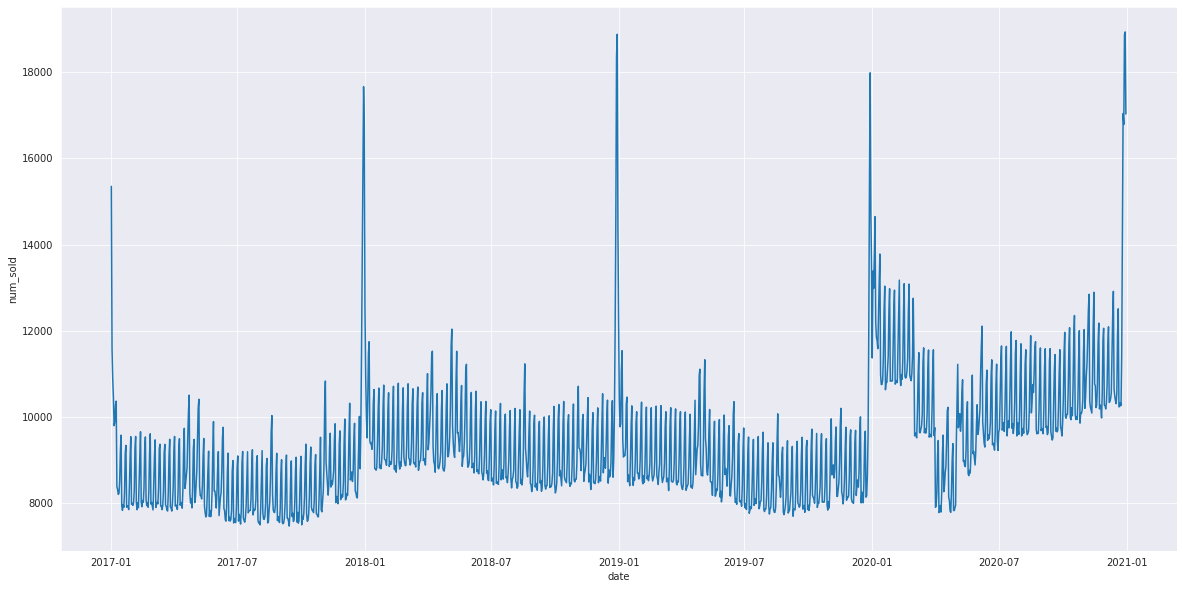

In [39]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train, x='date', y='num_sold');

위 모습이 우리가 예측해야 하는 시계열 데이터임  
2020년의 특이한 패턴은 예측을 더 어렵게 하고 있음

In [40]:
# 주간, 월간 판매량 데이터프레임 생성
weekly_df = train.groupby([pd.Grouper(key='date', freq='W')])['num_sold'].sum().rename('num_sold').reset_index()
monthly_df = train.groupby([pd.Grouper(key='date', freq='MS')])['num_sold'].sum().rename('num_sold').reset_index()

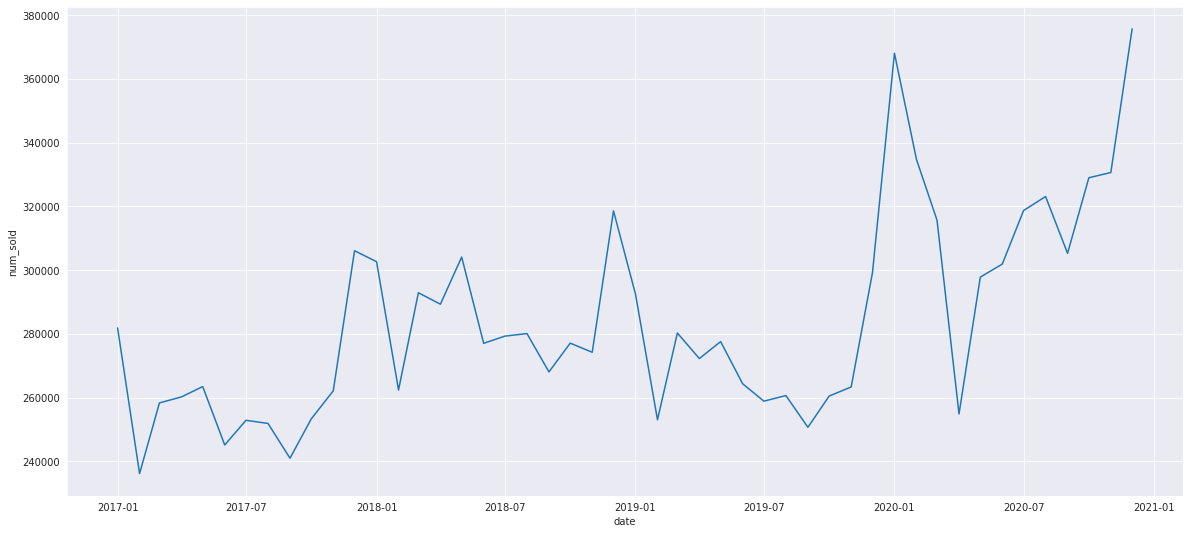

In [41]:
# 월간 판매량 시계열 그래프 작성
f, ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x='date', y='num_sold');

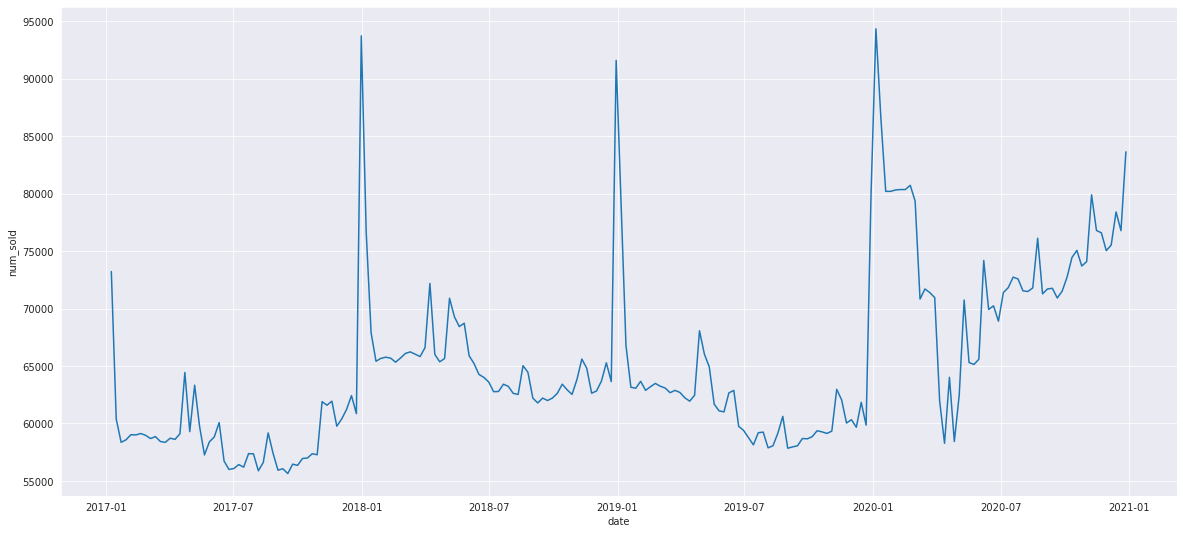

In [42]:
f, ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df[1:-1], x='date', y='num_sold');

## 계절성(Seasonality)

In [43]:
def plot_seasonality(df, x_axis):
    
    # 윤년에 해당하는 2월 29일 날짜 제거(remove the leap year date)
    df = df.loc[df['date'] != '2020-02-29'].copy()
    
    # 새로운 column 생성
    df['month'] = df['date'].dt.month # 월
    df['day_of_week'] = df['date'].dt.dayofweek # 요일
    df['day_of_year'] = df['date'].dt.dayofyear # 연 기준 날짜
    
    # 윤년에 대한 계산(account for leap year)
    df['day_of_year'] = df.apply(lambda x: x['day_of_year']-1 if x['date'] > pd.Timestamp('2020-02-29') 
                                 else x['day_of_year'], axis=1)
    
    df_no_2020 = df.loc[df['date'] < '2020-01-01']
    
    f, axes = plt.subplots(2,1, figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y='num_sold', ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y='num_sold', ax=axes[1]);
    axes[0].set_title('{} Seasonality - all years'.format(x_axis))
    axes[1].set_title('{} Seasonality - not including 2020'.format(x_axis))

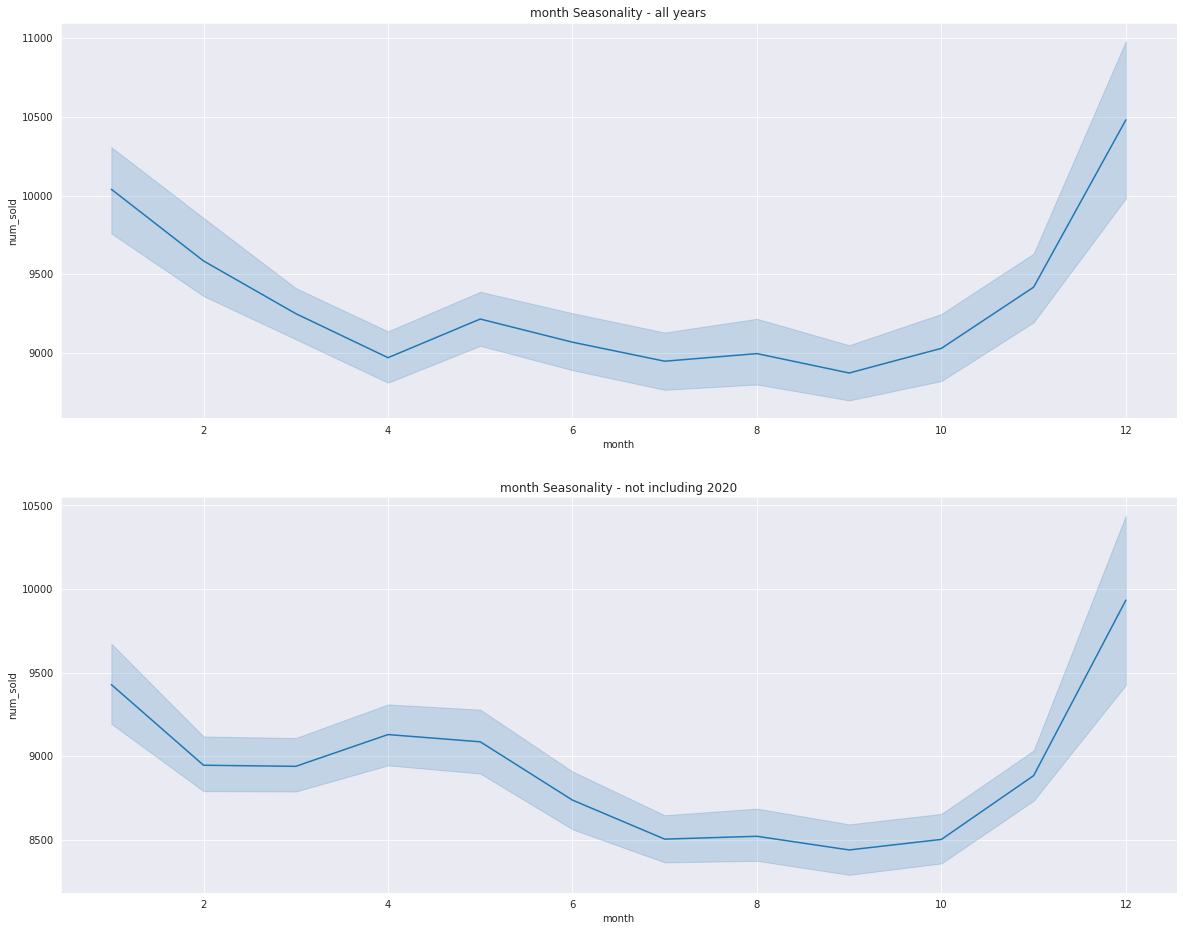

In [44]:
# 월간 계절성 그래프
plot_seasonality(train, 'month')

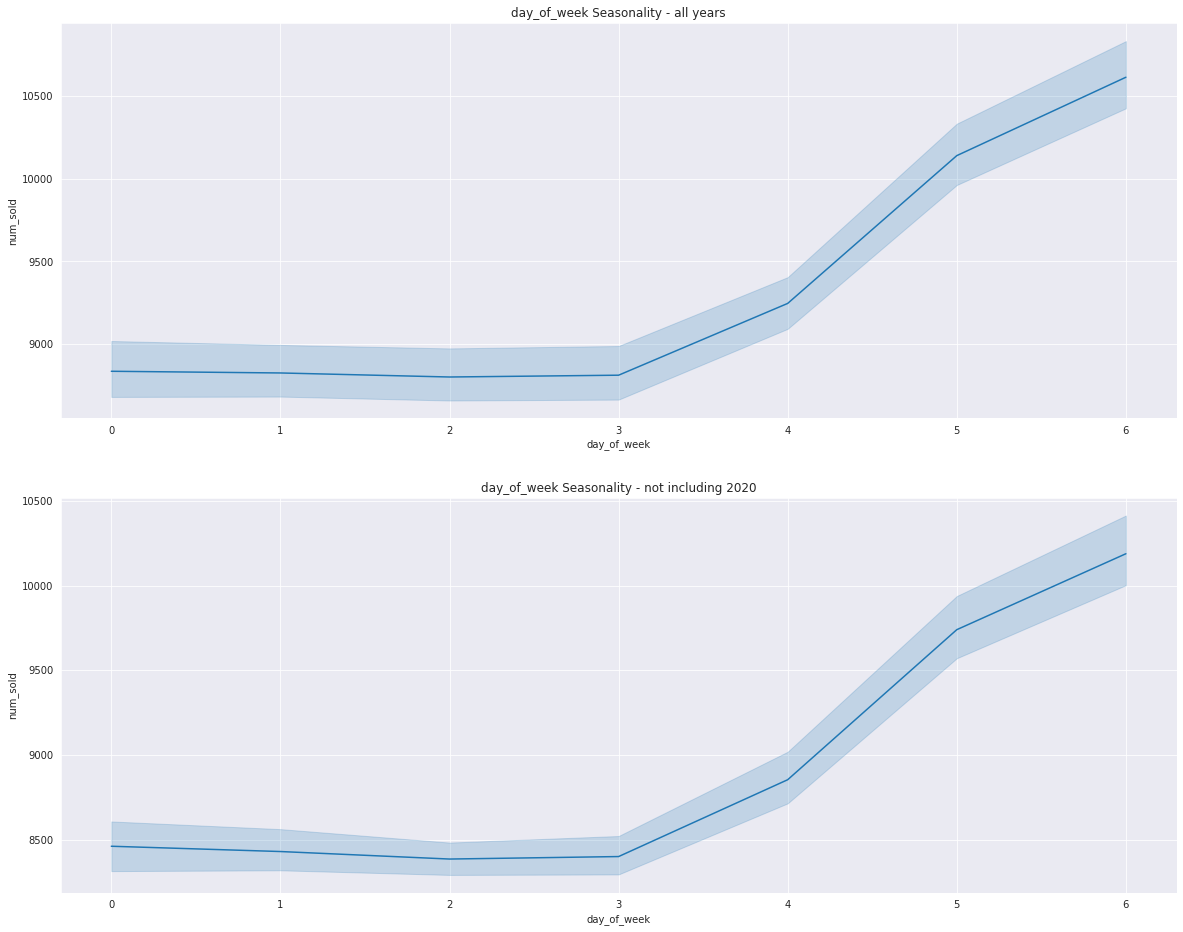

In [45]:
# 요일간 계절성 그래프
plot_seasonality(train, 'day_of_week')

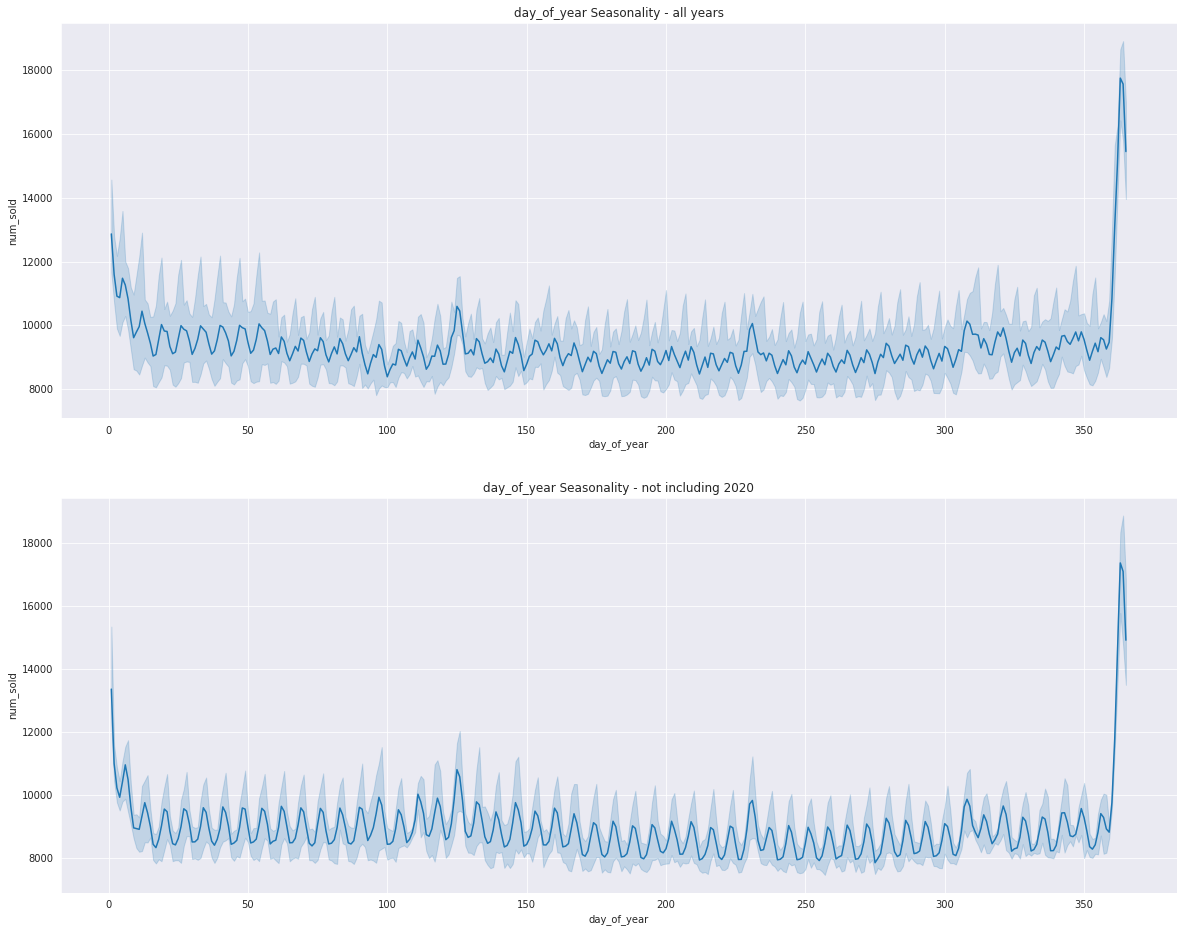

In [46]:
# 연간 계절성 그래프
plot_seasonality(train, 'day_of_year')

In [47]:
# 뒤에 모델링 때문에 필요한 과정 추가
tmp = train.copy()
tmp['day_of_year'] = tmp['date'].dt.dayofyear

In [48]:
tmp1 = tmp.groupby('day_of_year')['num_sold'].sum().reset_index()
tmp2 = tmp1[tmp1['num_sold'] > 40600]['day_of_year']
tmp2.values

array([  1,   2,   3,   4,   5,   6,   7,   8,  12, 124, 125, 126, 320,
       360, 361, 362, 363, 364, 365])

위 방법이 정확하진 않음  
뒤에 모델링에서 'important_dates'로 구분한 기준이 아마 판매량이 많았던 날들인것 같아서 위와 유사한 방식으로 날짜를 찾은 것 같음

# Preprocessing

2가지 예측 데이터가 필요했음:  
1. **판매 총액(Total sales)** 예측 데이터
2. **제품별 판매 비율(Product Sales Ratio)** 예측 데이터

## 1. 판매 총액(Total sales) 예측 데이터  

다시 한번 예측하고자 하는 판매 데이터 그래프를 그려보았음

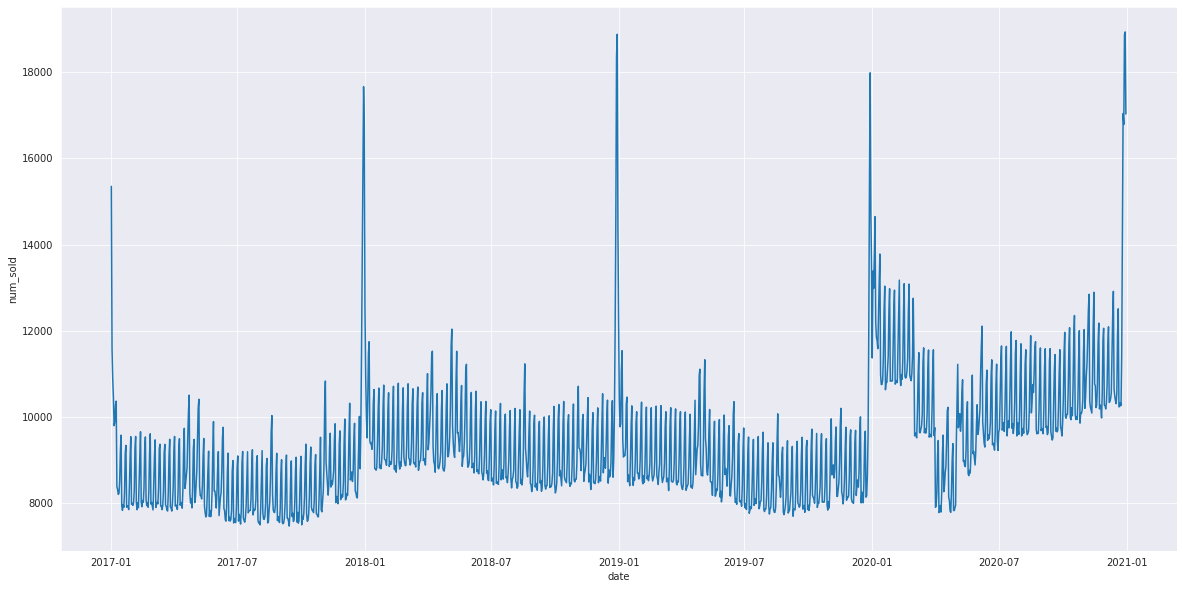

In [49]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train, x='date', y='num_sold');

2020년에 대해서는 적어도 2가지 중요한 사실을 고려해야 함:
1. 모든 국가에서의 판매량이 거의 동일해졌음 -> 이게 판매된 제품 총량(total number of products sold)을 크게 증가시켰음
2. 코로나의 영향을 무시할 수 없음 -> 특히 2020년 3월~5월의 데이터  

- 위 사실 중 1번의 영향은 2021년에도 바뀌지 않을 것이라고 추측하겠음  
- 그러나 2번(코로나)의 영향은 바뀔 것이라고 가정하여, 2020년 3월~5월의 데이터는 예측에서 완전히 제외하는 쪽을 택하였음

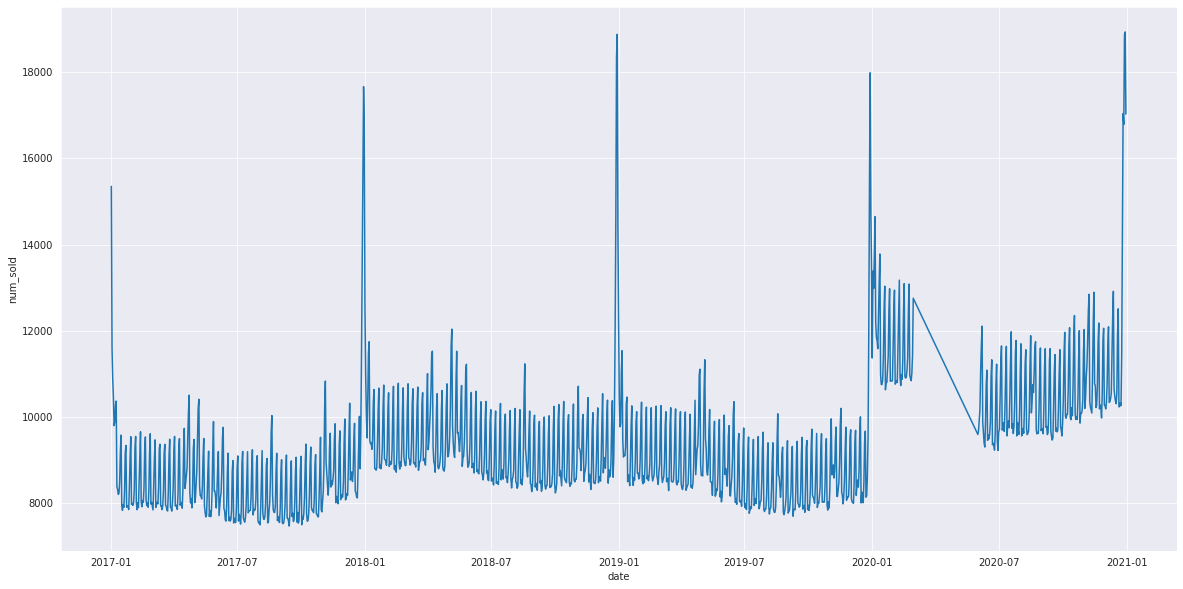

In [50]:
# 코로나의 영향을 받은 달의 데이터를 제외한 데이터프레임 생성
train_nocovid_df = train.loc[~((train['date'] >= '2020-03-01') & (train['date'] < '2020-06-01'))]
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=train_nocovid_df, x='date', y='num_sold');

In [51]:
# 예측해야 하는 날짜들 불러오기(get the dates to forecast for)
test_total_sales_df = test.groupby(['date'])['row_id'].first().reset_index().drop(columns='row_id')

# 나중을 위해 날짜들을 저장(keep dates for later)
test_total_sales_dates = test_total_sales_df[['date']]

**아래 함수가 가장 중요한 부분!**

In [52]:
def feature_engineer(df):
    new_df = df.copy()
    new_df['month'] = df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    
    # 0926 추가 부분
    new_df['day'] = df['date'].dt.day
    new_df['day_sin'] = np.sin(new_df['day'] * (2 * np.pi / 12))
    
    
    new_df['day_of_week'] = df['date'].dt.dayofweek
    # 위에서 day_of_week 그래프 출력 당시 0~3은 거의 비슷하고 4, 5, 6으로 갈수록 높아졌으므로
    # 비슷했던 0~3 -> 0, 4 -> 1, 5 -> 2, 6 -> 3으로 바꾸는 작업 수행
    new_df['day_of_week'] = new_df['day_of_week'].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    
    # 0926 추가 부분
    new_df['friday'] = new_df.date.dt.weekday.eq(4).astype(np.uint8)
    new_df['saturday'] = new_df.date.dt.weekday.eq(5).astype(np.uint8)
    new_df['sunday'] = new_df.date.dt.weekday.eq(6).astype(np.uint8)
    new_df['sat+sun'] = new_df['saturday'] + new_df['sunday']
    new_df['fri+sun'] = new_df['friday'] + new_df['sunday']
    
    
    new_df['day_of_year'] = df['date'].dt.dayofyear
    # 윤년에 대한 계산(account for leap year)
    new_df['day_of_year'] = new_df.apply(lambda x: x['day_of_year']-1 if (x['date'] > pd.Timestamp('2020-02-29') and x['date'] < pd.Timestamp('2021-01-01')) 
                                        else x['day_of_year'], axis=1)
    
    
    # 0926 추가 및 변경 부분
    # important_dates 기존보다 더 늘리고 여기에 따로 지정
    # important_dates: 위에서 day_of_year 그래프 출력 당시 유독 판매량이 높았던 날짜들
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 22, 23, 24, 
                       105, 123, 124, 125, 126, 127, 140, 141, 142, 167, 168, 169, 
                       170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 203, 
                       230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 
                       311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]  
    new_df['important_dates'] = new_df['day_of_year'].apply(lambda x: x if x in 
                                                           important_dates else 0)
    #new_df['day_of_year'].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df['year'] = df['date'].dt.year
    
    
    # 0926 추가된 부분
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    # 부활절 휴가철을 따로 고려
    for day in list(range(-5,5)) + list(range(40,48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    for col in new_df.columns:
        if 'easter' in col:
            new_df = pd.get_dummies(new_df, columns=[col], drop_first=True)
    # 크리스마스 휴가철을 따로 고려
    for day in range(24,32):
        new_df[f'Dec_{day}'] = new_df.date.dt.day.eq(day) & new_df.date.dt.month.eq(12)
    
    
    # 필요없는 열 제거(0926: column 중 'day'가 추가됨)
    new_df = new_df.drop(columns=['date', 'month', 'day', 'day_of_year'])
    # 범주형 변수는 0,1로만 나타내기 위해 더미 변수화 진행
    new_df = pd.get_dummies(new_df, columns=['important_dates', 'day_of_week'], drop_first=True)
    
    
    return new_df

In [53]:
# 0926 추가된 부분
# holidays 모듈을 사용하면 각 국가의 공휴일을 알 수 있음!

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]
    
    holiday_BE = holidays.CountryHoliday('BE', years=years_list)
    holiday_FR = holidays.CountryHoliday('FR', years=years_list)
    holiday_DE = holidays.CountryHoliday('DE', years=years_list)
    holiday_IT = holidays.CountryHoliday('IT', years=years_list)
    holiday_PL = holidays.CountryHoliday('PL', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)
    
    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)
    
    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [54]:
# 0926 추가된 부분

def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    
    return df

In [55]:
# 0926 추가된 부분
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

### 앞에 정의한 함수들을 적용:

In [56]:
# 변경 전 확인
display(train_nocovid_df.head(3))
display(test_total_sales_df.head(3))

date  num_sold
0 2017-01-01     15352
1 2017-01-02     11578
2 2017-01-03     10884

date
0 2021-01-01
1 2021-01-02
2 2021-01-03

In [109]:
# 변경 전 train 전체 개수 확인
display(train_nocovid_df.shape)

(1369, 4)

In [57]:
# 코로나의 영향을 받은 달의 데이터를 제외한 데이터프레임을 선택
train_total_sales_df = get_holidays(train_nocovid_df)
test_total_sales_df = get_holidays(test_total_sales_df)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [58]:
train_total_sales_df = feature_engineer(train_total_sales_df)
test_total_sales_df = feature_engineer(test_total_sales_df)

In [59]:
train_total_sales_df = encode_holiday_names(train_total_sales_df, oe)
test_total_sales_df = encode_holiday_names(test_total_sales_df, oe)

In [60]:
# 변경 후 확인
display(train_total_sales_df.head(3))
display(test_total_sales_df.head(3))

num_sold  holiday_name  is_holiday  month_sin  month_cos   day_sin  friday  \
0     15352          26.0           1        0.5   0.866025  0.500000       0   
1     11578           3.0           1        0.5   0.866025  0.866025       0   
2     10884          25.0           0        0.5   0.866025  1.000000       0   

   saturday  sunday  sat+sun  ...  important_dates_320  important_dates_360  \
0         0       1        1  ...                    0                    0   
1         0       0        0  ...                    0                    0   
2         0       0        0  ...                    0                    0   

   important_dates_361  important_dates_362  important_dates_363  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

   important_dates_364  important_dates_365  day_of_week_1  day_of_week_2  \
0                    0                    0              0              0   
1                    0                    0              0              0   
2                    0                    0              0              0   

   day_of_week_3  
0              1  
1              0  
2              0  

[3 rows x 107 columns]

holiday_name  is_holiday  month_sin  month_cos   day_sin  friday  saturday  \
0           2.0           1        0.5   0.866025  0.500000       1         0   
1          19.0           0        0.5   0.866025  0.866025       0         1   
2          19.0           0        0.5   0.866025  1.000000       0         0   

   sunday  sat+sun  fri+sun  ...  important_dates_320  important_dates_360  \
0       0        0        1  ...                    0                    0   
1       0        1        0  ...                    0                    0   
2       1        1        1  ...                    0                    0   

   important_dates_361  important_dates_362  important_dates_363  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

   important_dates_364  important_dates_365  day_of_week_1  day_of_week_2  \
0                    0                    0              1              0   
1                    0                    0              0              1   
2                    0                    0              0              0   

   day_of_week_3  
0              0  
1              0  
2              1  

[3 rows x 106 columns]

In [110]:
# 변경 후 전체 확인
display(train_total_sales_df)
display(test_total_sales_df)

num_sold  holiday_name  is_holiday     month_sin  month_cos  \
0        15352          26.0           1  5.000000e-01   0.866025   
1        11578           3.0           1  5.000000e-01   0.866025   
2        10884          25.0           0  5.000000e-01   0.866025   
3        10445          25.0           0  5.000000e-01   0.866025   
4         9795          25.0           0  5.000000e-01   0.866025   
...        ...           ...         ...           ...        ...   
1456     17042          25.0           0 -2.449294e-16   1.000000   
1457     16789          25.0           0 -2.449294e-16   1.000000   
1458     18876          25.0           0 -2.449294e-16   1.000000   
1459     18938          25.0           0 -2.449294e-16   1.000000   
1460     17031          25.0           0 -2.449294e-16   1.000000   

           day_sin  friday  saturday  sunday  sat+sun  ...  \
0     5.000000e-01       0         0       1        1  ...   
1     8.660254e-01       0         0       0        0  ...   
2     1.000000e+00       0         0       0        0  ...   
3     8.660254e-01       0         0       0        0  ...   
4     5.000000e-01       0         0       0        0  ...   
...            ...     ...       ...     ...      ...  ...   
1456  1.000000e+00       0         0       1        1  ...   
1457  8.660254e-01       0         0       0        0  ...   
1458  5.000000e-01       0         0       0        0  ...   
1459  2.388680e-15       0         0       0        0  ...   
1460 -5.000000e-01       0         0       0        0  ...   

      important_dates_320  important_dates_360  important_dates_361  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       0                    0                    0   
3                       0                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
1456                    0                    0                    1   
1457                    0                    0                    0   
1458                    0                    0                    0   
1459                    0                    0                    0   
1460                    0                    0                    0   

      important_dates_362  important_dates_363  important_dates_364  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       0                    0                    0   
3                       0                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
1456                    0                    0                    0   
1457                    1                    0                    0   
1458                    0                    1                    0   
1459                    0                    0                    1   
1460                    0                    0                    0   

      important_dates_365  day_of_week_1  day_of_week_2  day_of_week_3  
0                       0              0              0              1  
1                       0              0              0              0  
2                       0              0              0              0  
3                       0              0              0              0  
4                       0              0              0              0  
...                   ...            ...            ...            ...  
1456                    0              0              0              1  
1457                    0              0              0              0  
1458                    0              0              0              

holiday_name  is_holiday     month_sin  month_cos       day_sin  friday  \
0             2.0           1  5.000000e-01   0.866025  5.000000e-01       1   
1            19.0           0  5.000000e-01   0.866025  8.660254e-01       0   
2            19.0           0  5.000000e-01   0.866025  1.000000e+00       0   
3            19.0           0  5.000000e-01   0.866025  8.660254e-01       0   
4            19.0           0  5.000000e-01   0.866025  5.000000e-01       0   
..            ...         ...           ...        ...           ...     ...   
360          19.0           0 -2.449294e-16   1.000000  1.000000e+00       0   
361          19.0           0 -2.449294e-16   1.000000  8.660254e-01       0   
362          19.0           0 -2.449294e-16   1.000000  5.000000e-01       0   
363          19.0           0 -2.449294e-16   1.000000  2.388680e-15       0   
364          19.0           0 -2.449294e-16   1.000000 -5.000000e-01       1   

     saturday  sunday  sat+sun  fri+sun  ...  important_dates_320  \
0           0       0        0        1  ...                    0   
1           1       0        1        0  ...                    0   
2           0       1        1        1  ...                    0   
3           0       0        0        0  ...                    0   
4           0       0        0        0  ...                    0   
..        ...     ...      ...      ...  ...                  ...   
360         0       0        0        0  ...                    0   
361         0       0        0        0  ...                    0   
362         0       0        0        0  ...                    0   
363         0       0        0        0  ...                    0   
364         0       0        0        1  ...                    0   

     important_dates_360  important_dates_361  important_dates_362  \
0                      0                    0                    0   
1                      0                    0                    0   
2                      0                    0                    0   
3                      0                    0                    0   
4                      0                    0                    0   
..                   ...                  ...                  ...   
360                    0                    1                    0   
361                    0                    0                    1   
362                    0                    0                    0   
363                    0                    0                    0   
364                    0                    0                    0   

     important_dates_363  important_dates_364  important_dates_365  \
0                      0                    0                    0   
1                      0                    0                    0   
2                      0                    0                    0   
3                      0                    0                    0   
4                      0                    0                    0   
..                   ...                  ...                  ...   
360                    0                    0                    0   
361                    0                    0                    0   
362                    1                    0                    0   
363                    0                    1                    0   
364                    0                    0                    1   

     day_of_week_1  day_of_week_2  day_of_week_3  
0                1              0              0  
1                0              1              0  
2                0              0              1  
3                0              0              0  
4                0              0              0  
..             ...            ...            ...  
360              0              0              0  
361              0              0              0  
362              0              0              0  
363              0     

In [106]:
# 전체 개수 확인
display(train_total_sales_df.shape)
display(test_total_sales_df.shape)

(1369, 107)

(365, 106)

In [108]:
# 전체 column 이름 확인
display(train_total_sales_df.columns.values)
display(test_total_sales_df.columns.values)

array(['num_sold', 'holiday_name', 'is_holiday', 'month_sin', 'month_cos',
       'day_sin', 'friday', 'saturday', 'sunday', 'sat+sun', 'fri+sun',
       'year', 'easter_-5_True', 'easter_-4_True', 'easter_-3_True',
       'easter_-2_True', 'easter_-1_True', 'easter_0_True',
       'easter_1_True', 'easter_2_True', 'easter_3_True', 'easter_4_True',
       'easter_40_True', 'easter_41_True', 'easter_42_True',
       'easter_43_True', 'easter_44_True', 'easter_45_True',
       'easter_46_True', 'easter_47_True', 'Dec_24', 'Dec_25', 'Dec_26',
       'Dec_27', 'Dec_28', 'Dec_29', 'Dec_30', 'Dec_31',
       'important_dates_1', 'important_dates_2', 'important_dates_3',
       'important_dates_4', 'important_dates_5', 'important_dates_6',
       'important_dates_7', 'important_dates_8', 'important_dates_9',
       'important_dates_10', 'important_dates_11', 'important_dates_12',
       'important_dates_16', 'important_dates_17', 'important_dates_22',
       'important_dates_23', 'important_d

array(['holiday_name', 'is_holiday', 'month_sin', 'month_cos', 'day_sin',
       'friday', 'saturday', 'sunday', 'sat+sun', 'fri+sun', 'year',
       'easter_-5_True', 'easter_-4_True', 'easter_-3_True',
       'easter_-2_True', 'easter_-1_True', 'easter_0_True',
       'easter_1_True', 'easter_2_True', 'easter_3_True', 'easter_4_True',
       'easter_40_True', 'easter_41_True', 'easter_42_True',
       'easter_43_True', 'easter_44_True', 'easter_45_True',
       'easter_46_True', 'easter_47_True', 'Dec_24', 'Dec_25', 'Dec_26',
       'Dec_27', 'Dec_28', 'Dec_29', 'Dec_30', 'Dec_31',
       'important_dates_1', 'important_dates_2', 'important_dates_3',
       'important_dates_4', 'important_dates_5', 'important_dates_6',
       'important_dates_7', 'important_dates_8', 'important_dates_9',
       'important_dates_10', 'important_dates_11', 'important_dates_12',
       'important_dates_16', 'important_dates_17', 'important_dates_22',
       'important_dates_23', 'important_dates_24', 'i

In [61]:
# train_total_sales_df에서 X와 y 분리
y = train_total_sales_df['num_sold']
X = train_total_sales_df.drop(columns='num_sold')
X_test = test_total_sales_df

# Modeling

**모델을 정의한 후 훈련 및 예측 수행**

In [62]:
# 모델의 성능 지표인 smape 함수 정의
def smape(y_true, y_pred):
    smape = abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 200
    return smape

이전에는 시도하지 않았던 **train 데이터의 train_test_split** 진행 후 모델링에 활용

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [64]:
# sklearn.linear_model 계열 모델링 수행
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_preds = linear_model.predict(x_test)

ridge_model = Ridge(tol=1e-2, max_iter=100000, random_state=42)
ridge_model.fit(x_train, y_train)
ridge_preds = ridge_model.predict(x_test)

lasso_model = Lasso(tol=1e-2, max_iter=100000, random_state=42)
lasso_model.fit(x_train, y_train)
lasso_preds = lasso_model.predict(x_test)

elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.01, random_state=42)
elastic_model.fit(x_train, y_train)
elastic_preds = elastic_model.predict(x_test)


print('lr_pre: ', smape(y_test, linear_preds))
print('ridge_pre: ', smape(y_test, ridge_preds))
print('lasso_pre: ', smape(y_test, lasso_preds))
print('elastic_pre: ', smape(y_test, elastic_preds))

lr_pre:  6.873702245348677
ridge_pre:  5.576696765774133
lasso_pre:  5.494429635156214
elastic_pre:  5.9227266998681


각 모델의 최적의 파라미터를 찾기 위해 **GridSearchCV** 적용

In [65]:
# ridge 모델에 GridSearchCV 적용
ridge_params = {'alpha': 0.0001 * np.arange(1, 1000)}
grid_ri = GridSearchCV(estimator=ridge_model, param_grid=ridge_params, 
                    scoring='neg_mean_absolute_error')
grid_ri.fit(X, y)
best_param_ri = grid_ri.best_params_
print(best_param_ri)

{'alpha': 0.0999}


In [66]:
ridge_model2 = Ridge(alpha=0.0999, tol=1e-2, max_iter=100000, random_state=42)
ridge_model2.fit(x_train, y_train)
ridge_preds2 = ridge_model2.predict(x_test)
print('ridge_pre2: ', smape(y_test, ridge_preds2))

ridge_pre2:  5.575966478371319


In [67]:
# lasso 모델에 GridSearchCV 적용
lasso_params = {'alpha': 0.0001 * np.arange(1, 1000)}
grid_la = GridSearchCV(estimator=lasso_model, param_grid=lasso_params, 
                       scoring='neg_mean_absolute_error')
grid_la.fit(X, y)
best_param_la = grid_la.best_params_
print(best_param_la)

{'alpha': 0.0999}


In [68]:
lasso_model2 = Lasso(alpha=0.0999, tol=1e-2, max_iter=100000, random_state=42)
lasso_model2.fit(x_train, y_train)
lasso_preds2 = lasso_model2.predict(x_test)
print('lasso_pre2: ', smape(y_test, lasso_preds2))

lasso_pre2:  5.570014724724361


In [69]:
# elasticnet 모델에 GridSearchCV 적용
elastic_params = {'alpha': 0.0001 * np.arange(1, 100),
                 'l1_ratio': 0.001 * np.arange(1, 10)}
grid_el = GridSearchCV(estimator=elastic_model, param_grid=elastic_params,
                      scoring='neg_mean_squared_error')
grid_el.fit(X, y)
best_param_el = grid_el.best_params_
print(best_param_el)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.493e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.708e+07, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.568e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.340e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e+08, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.555e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+08, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.830e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.678e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.487e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.475e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.687e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+08, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+08, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e+08, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+08, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.592e+08, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+08, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.330e+07, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.522e+07, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+07, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+08, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+07, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e+07, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+06, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.685e+06, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e+07, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+07, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.021e+06, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.069e+06, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.832e+06, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.363e+06, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e+06, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e+06, tolerance: 2.526e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.741e+05, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.777e+05, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.517e+05, tolerance: 2.423e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e+05, tolerance: 2.497e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.397e+05, tolerance: 2.462e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.978e+05, tolerance: 1.527e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'alpha': 0.00030000000000000003, 'l1_ratio': 0.001}


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e+08, tolerance: 2.922e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [70]:
elastic_model2 = ElasticNet(alpha=0.00030000000000000003, l1_ratio=0.001, random_state=42)
elastic_model2.fit(x_train, y_train)
elastic_preds2 = elastic_model2.predict(x_test)
print('elastic_pre2: ', smape(y_test, elastic_preds2))

elastic_pre2:  5.559613012536032


/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e+08, tolerance: 1.960e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


각 모델에 **GroupKFold 교차검증** 수행

In [71]:
# LinearRegression KFold
linear_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for train_idx, test_idx in kf.split(X, groups=X.year):
    x_train, x_valid = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    linear_model = LinearRegression()
    linear_model.fit(x_train, y_train)
    
    y_pred = linear_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)
    
    n = n + 1
    
    test_pred = linear_model.predict(X_test)
    pred = pd.Series(test_pred)
    
    linear_preds += pred / kf.n_splits

print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.872191981784137


In [72]:
linear_preds

0      14256.288517
1      14344.515080
2      13978.991642
3      11818.982334
4      11981.262133
           ...     
360    13943.184814
361    16054.086369
362    18263.279606
363    18188.354923
364    16858.583439
Length: 365, dtype: float64

In [73]:
# ridge KFold
ridge_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for train_idx, test_idx in kf.split(X, groups=X.year):
    x_train, x_valid = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    ridge_model = Ridge(alpha=0.0999, tol=1e-2, max_iter=100000, random_state=42)
    ridge_model.fit(x_train, y_train)
    
    y_pred = ridge_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)
    
    n = n + 1
    
    test_pred = ridge_model.predict(X_test)
    pred = pd.Series(test_pred)
    
    ridge_preds += pred / kf.n_splits

print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.856854422718119


In [74]:
ridge_preds

0      14155.382054
1      14252.236328
2      13920.968884
3      11774.109892
4      11931.647067
           ...     
360    13883.879966
361    15960.594250
362    18133.605222
363    18060.263620
364    16758.129877
Length: 365, dtype: float64

In [75]:
# lasso KFold
lasso_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for train_idx, test_idx in kf.split(X, groups=X.year):
    x_train, x_valid = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    lasso_model = Lasso(alpha=0.0999, tol=1e-2, max_iter=100000, random_state=42)
    lasso_model.fit(x_train, y_train)
    
    y_pred = lasso_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)
    
    n = n + 1
    
    test_pred = lasso_model.predict(X_test)
    pred = pd.Series(test_pred)
    
    lasso_preds += pred / kf.n_splits

print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.85695827743616


In [76]:
lasso_preds

0      14229.869891
1      14299.906855
2      13941.285955
3      11783.288901
4      11946.678296
           ...     
360    13907.697202
361    16018.601954
362    18228.475962
363    18154.151744
364    16822.359162
Length: 365, dtype: float64

In [77]:
#elasticnet KFold
elastic_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for train_idx, test_idx in kf.split(X, groups=X.year):
    x_train, x_valid = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    elastic_model = ElasticNet(alpha=0.00030000000000000003, l1_ratio=0.001, 
                               tol=1e-2, max_iter=100000, random_state=42)
    elastic_model.fit(x_train, y_train)
    
    y_pred = elastic_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)
    
    n = n + 1
    
    test_pred = elastic_model.predict(X_test)
    pred = pd.Series(test_pred)
    
    elastic_preds += pred / kf.n_splits

print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.833526130531444


In [78]:
elastic_preds

0      13956.498363
1      14092.716226
2      13820.930801
3      11697.814574
4      11845.568813
           ...     
360    13773.697451
361    15782.154008
362    17883.512879
363    17812.221158
364    16565.876573
Length: 365, dtype: float64

In [79]:
test_total_sales_dates['num_sold'] = ridge_preds * 0.5 + lasso_preds * 0.4 + elastic_preds * 0.1 + linear_preds * 0
#test_total_sales_dates["num_sold"] = ridge_preds * 0.3 + lasso_preds * 0.4 + linear_preds * 0.3 + elastic_preds * 0
#test_total_sales_dates["num_sold"] = ridge_preds * 0.2 + lasso_preds * 0.2 + linear_preds * 0.6 + elastic_preds * 0
#test_total_sales_dates["num_sold"] = ridge_preds * 0.1 + lasso_preds * 0.1 + linear_preds * 0.8 + elastic_preds * 0
#test_total_sales_dates["num_sold"] = ridge_preds * 0.2 + lasso_preds * 0.2 + linear_preds * 0.3 + elastic_preds * 0.3
#test_total_sales_dates["num_sold"] = ridge_preds * 0.3 + lasso_preds * 0.3 + linear_preds * 0 + elastic_preds * 0.4
#test_total_sales_dates["num_sold"] = ridge_preds * 0.25 + lasso_preds * 0.25 + linear_preds * 0 + elastic_preds * 0.5

In [80]:
#ridge_preds * 0.5 + lasso_preds * 0.4 + elastic_preds * 0.1 + linear_preds * 0
test_total_sales_dates

date      num_sold
0   2021-01-01  14165.288820
1   2021-01-02  14255.352528
2   2021-01-03  13919.091904
3   2021-01-04  11770.151964
4   2021-01-05  11929.051733
..         ...           ...
360 2021-12-27  13882.388609
361 2021-12-28  15965.953308
362 2021-12-29  18146.544284
363 2021-12-30  18073.014623
364 2021-12-31  16764.596261

[365 rows x 2 columns]

In [81]:
models = [linear_model, ridge_model, lasso_model, elastic_model]

In [82]:
for i in range(len(models)):
    scores = cross_val_score(models[i], X, y, 
                             scoring=make_scorer(smape, greater_is_better=False))
    print(models[i], scores, np.mean(scores))

LinearRegression() [ -2.60456364  -5.7182657   -6.59524281 -13.1566204  -16.98507861] -9.011954231506559
Ridge(alpha=0.0999, max_iter=100000, random_state=42, tol=0.01) [ -2.6366624   -5.65320185  -6.60017067 -13.13662546 -16.96277144] -8.997886365411635
Lasso(alpha=0.0999, max_iter=100000, random_state=42, tol=0.01) [ -2.61300627  -5.67579779  -6.59353982 -13.12168883 -16.96336421] -8.993479385160555
ElasticNet(alpha=0.00030000000000000003, l1_ratio=0.001, max_iter=100000,
           random_state=42, tol=0.01) [ -2.7198028   -5.54968197  -6.60625206 -13.09814021 -16.9174046 ] -8.978256327536192


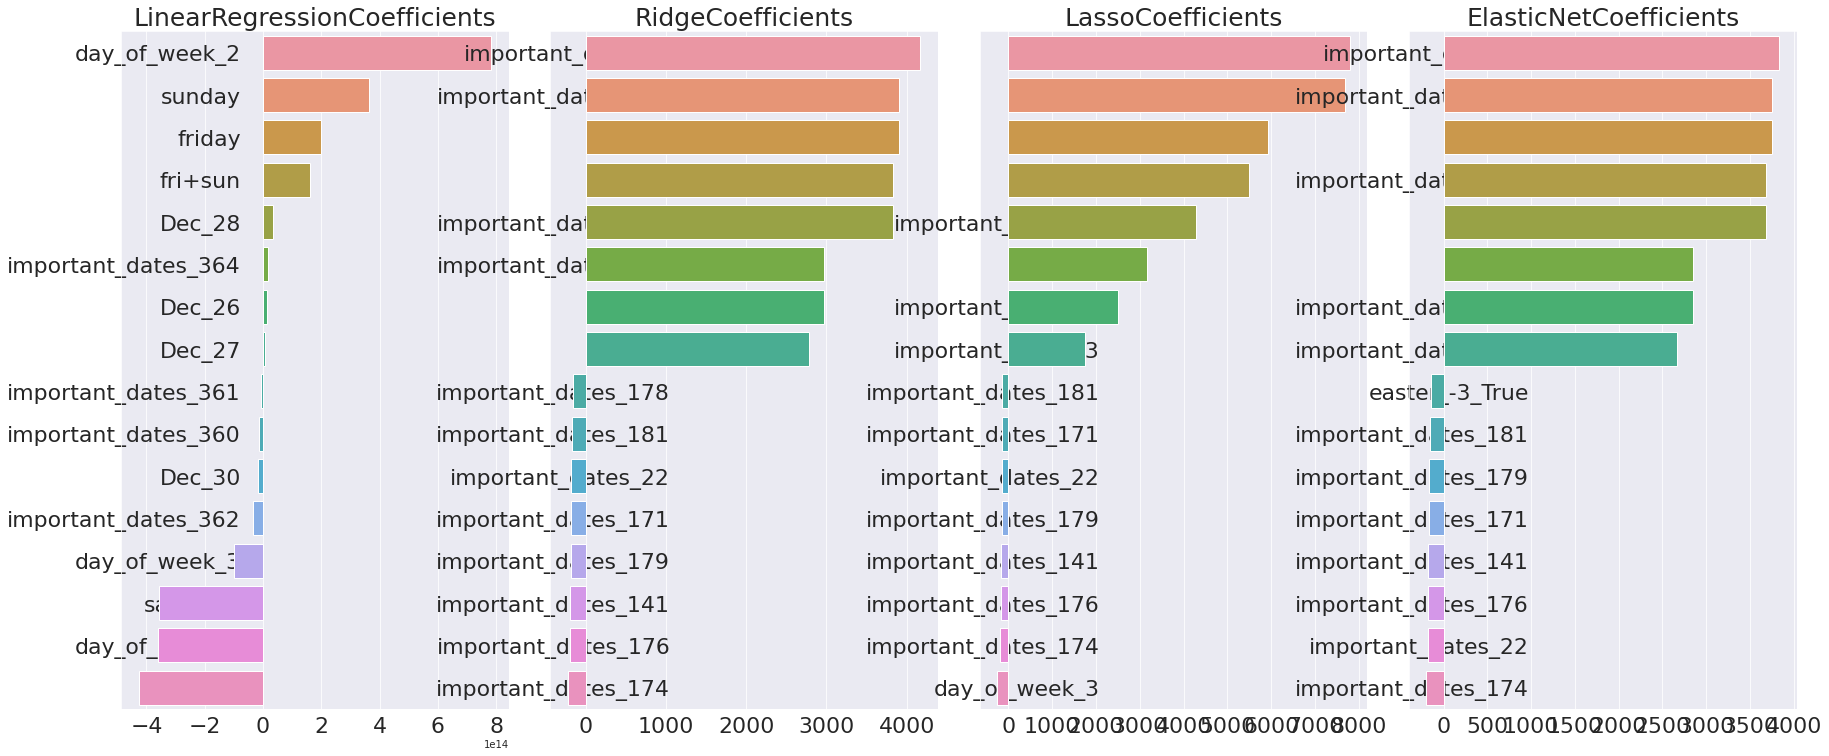

In [83]:
def get_top_bottom_coef(model, n=8):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=4)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+'Coefficients',size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
visualize_coefficient(models)

예측을 그래프로 시각화:

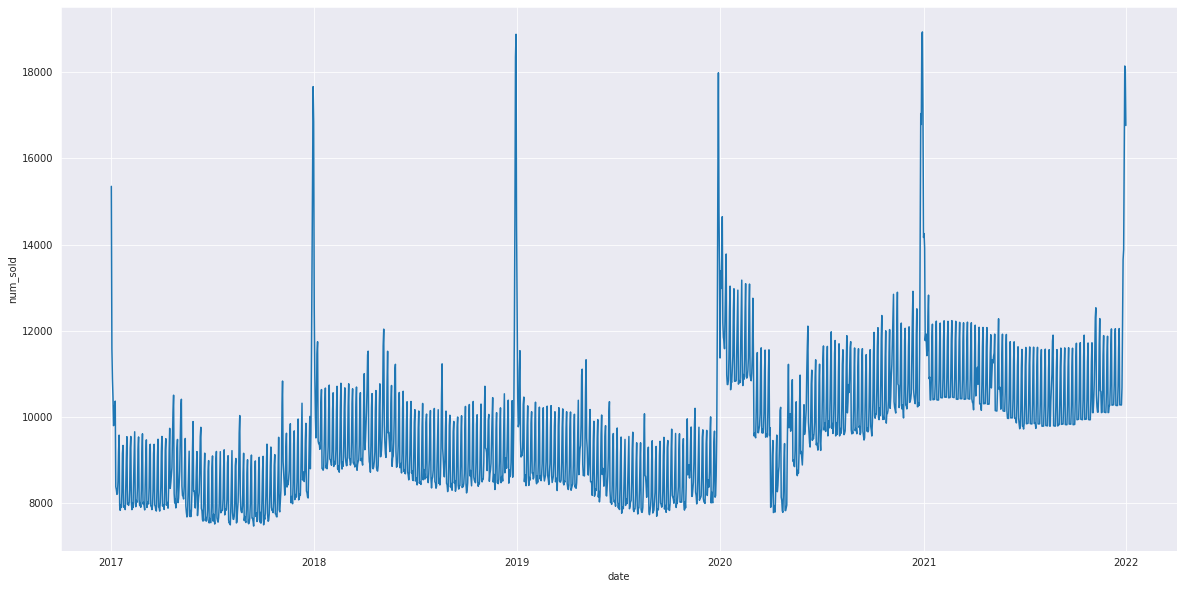

In [84]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=pd.concat([train, test_total_sales_dates]).reset_index(drop=True), x='date', y='num_sold');

## 2. 제품별 판매 비율(Product Sales Ratio) 예측 데이터

이제 2021년의 제품별 판매 비율을 예측해야 함  

앞서 살펴본 결과 제품 비율의 sin 곡선의 주기가 약 2년으로 드러났음  
따라서 2021년을 예측하기 위해  
2년 전인 2019년만의 비율,  
2017~2019년 3개년 비율의 평균,  
2017&2019년 2개년 비율을 사용해본 결과  
2017&2019년 2개년 비율을 사용한 것이 제일 결과가 좋았음

In [85]:
# 2017년 제품 비율
product_ratio_2017 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2017].copy()
product_ratio_2017['mm-dd'] = product_ratio_2017['date'].dt.strftime('%m-%d')
product_ratio_2017 = product_ratio_2017.drop(columns='date')
product_ratio_2017 = product_ratio_2017.reset_index()

In [86]:
# 2018년 제품 비율
product_ratio_2018 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2018].copy()
product_ratio_2018['mm-dd'] = product_ratio_2018['date'].dt.strftime('%m-%d')
product_ratio_2018 = product_ratio_2018.drop(columns='date')
product_ratio_2018 = product_ratio_2018.reset_index()

In [87]:
# 2019년 제품 비율
product_ratio_2019 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2019].copy()
product_ratio_2019['mm-dd'] = product_ratio_2019['date'].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns='date')
product_ratio_2019 = product_ratio_2019.reset_index()

In [88]:
# 2017~2019년 제품 비율의 평균
#product_ratio_2019['mean_ratios'] = (product_ratio_2017['ratios']
#                                    +product_ratio_2018['ratios']
#                                    +product_ratio_2019['ratios'])/3
#product_ratio_2019

위 부분처럼 3개년도를 3으로 나누는 대신 아래처럼 2017, 2019년 두 연도를 2로 나누는 것으로 평균 비율을 바꿈

In [89]:
product_ratio_2019['mean_ratios'] = (product_ratio_2017['ratios']
                                    +product_ratio_2019['ratios'])/2
product_ratio_2019

index                           product    ratios  mm-dd  mean_ratios
0      2920        Kaggle Advanced Techniques  0.279273  01-01     0.278609
1      2921            Kaggle Getting Started  0.230832  01-01     0.229147
2      2922                Kaggle Recipe Book  0.188119  01-01     0.188510
3      2923  Kaggle for Kids: One Smart Goose  0.301776  01-01     0.303734
4      2924        Kaggle Advanced Techniques  0.281654  01-02     0.280834
...     ...                               ...       ...    ...          ...
1455   4375  Kaggle for Kids: One Smart Goose  0.304807  12-30     0.304580
1456   4376        Kaggle Advanced Techniques  0.277440  12-31     0.279665
1457   4377            Kaggle Getting Started  0.224633  12-31     0.224087
1458   4378                Kaggle Recipe Book  0.191453  12-31     0.191352
1459   4379  Kaggle for Kids: One Smart Goose  0.306473  12-31     0.304896

[1460 rows x 5 columns]

In [90]:
test_product_ratio_df = test.copy()
test_product_ratio_df['mm-dd'] = test_product_ratio_df['date'].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df, product_ratio_2019, how='left', on=['mm-dd', 'product'])
test_product_ratio_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   mm-dd  index    ratios  mean_ratios  
0  01-01   2920  0.279273     0.278609  
1  01-01   2921  0.230832     0.229147  
2  01-01   2922  0.188119     0.188510  
3  01-01   2923  0.301776     0.303734  
4  01-01   2920  0.279273     0.278609

예측을 그래프로 시각화:

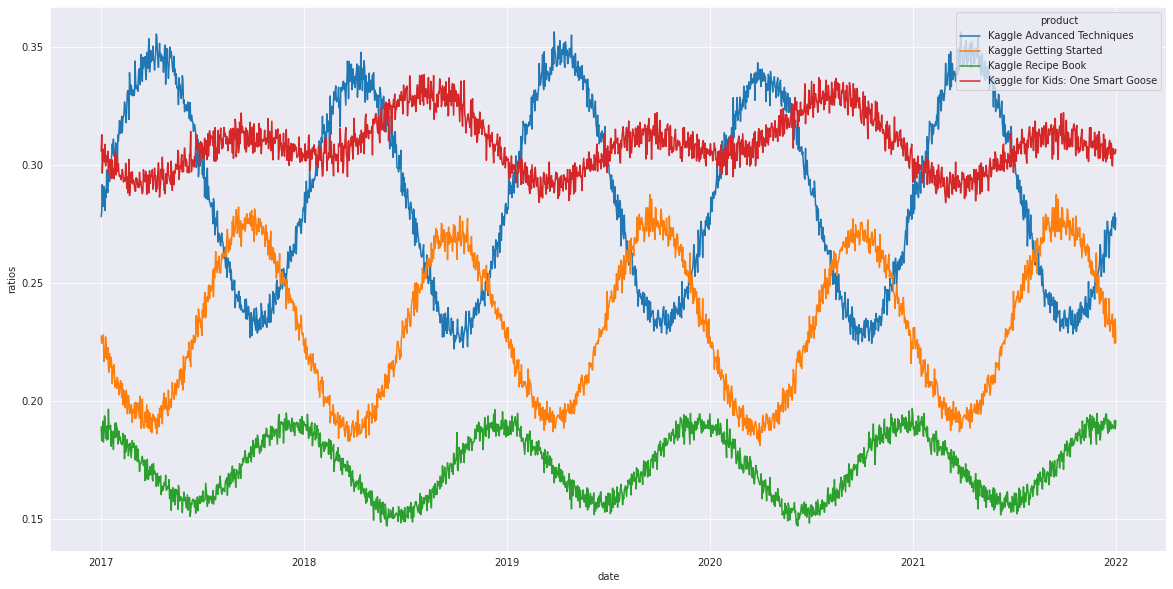

In [91]:
temp_df = pd.concat([product_ratio_df, test_product_ratio_df]).reset_index(drop=True)
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x='date', y='ratios', hue='product');

## 3. 판매 총액 예측 데이터 세분화(Disaggregating Total Sales Forecast

이제 2가지 예측 데이터를 확보하는데 성공하였기 때문에, 범주형 변수들(categorical variables) 간 판매 총액 예측 데이터를 분배해야 함

In [92]:
# 1번 예측 데이터(Total sales) 병합
test_sub_df = pd.merge(test, test_total_sales_dates, how='left')
# 2번 예측 데이터(Product Sales Ratio) 병합
test_sub_df['ratios'] = test_product_ratio_df['ratios']
test_sub_df['mean_ratios'] = test_product_ratio_df['mean_ratios']

test_sub_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

      num_sold    ratios  mean_ratios  
0  14165.28882  0.279273     0.278609  
1  14165.28882  0.230832     0.229147  
2  14165.28882  0.188119     0.188510  
3  14165.28882  0.301776     0.303734  
4  14165.28882  0.279273     0.278609

In [93]:
original_train_df.head()

row_id        date  country       store                           product  \
0       0  2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1  2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2  2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3  2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4  2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

In [94]:
# store 가중치 재확인
stores_weights = original_train_df.groupby('store')['num_sold'].sum() / original_train_df['num_sold'].sum()
print(store_weights)

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64


In [95]:
# country 가중치 재확인
country_weights = original_train_df.groupby('country')['num_sold'].sum() / original_train_df['num_sold'].sum()
print(country_weights)

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: num_sold, dtype: float64


### <주의> 위에서 구한 country_weights는 사용하지 않을 예정!  
이유: EDA 때 살펴본 그래프를 보면 직전년도인 2020년에는 `국가 간의 차이가 거의 없는 경향을 띠고 있었기 때문에` 예측 시에 사용할 country_weights는 그냥 **모든 국가에 동일하게 1/6씩 할당할 예정**  
(실제로 위의 country_weights를 사용하여 예측하면 최종 결과가 굉장히 안좋게 나왔음 = SMAPE가 20 정도로 굉장히 높게 측정됨) 

**최종 예상 판매량 예측을 위한 함수 정의:**

In [96]:
def disaggregate_forecast(df):
    new_df = df.copy()
    
    # 가게의 비율(가중치) 계산
    stores_weights = original_train_df.groupby('store')['num_sold'].sum() / original_train_df['num_sold'].sum()
    print(store_weights)
    # 국가의 비율(가중치) 계산
    country_weights = pd.Series(index = test_sub_df['country'].unique(), data = 1/6)
    print(country_weights)
    
    # 국가별 비율 적용
    for country in country_weights.index:
        new_df.loc[new_df['country'] == country, 'num_sold'] = new_df.loc[new_df['country'] == country, 'num_sold'] * country_weights[country]
    
    # 가게별 비율 적용
    for store in store_weights.index:
        new_df.loc[new_df['store'] == store, 'num_sold'] = new_df.loc[new_df['store'] == store, 'num_sold'] * store_weights[store]
        
    # 제품별 비율 적용(which is dependent on date)
    new_df['num_sold'] = new_df['num_sold'] * new_df['mean_ratios']
    new_df['num_sold'] = new_df['num_sold'].round() # 예측 결과를 정수 형태로 반올림
    new_df = new_df.drop(columns='ratios')
    
    return new_df

In [97]:
# 최종 예측 형태의 데이터프레임 저장 후 출력
final_df = disaggregate_forecast(test_sub_df)
final_df

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64
Belgium    0.166667
France     0.166667
Germany    0.166667
Italy      0.166667
Poland     0.166667
Spain      0.166667
dtype: float64


row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  num_sold  mean_ratios  
0            Kaggle Advanced Techniques     488.0     0.278609  
1                Kaggle Getting Started     402.0     0.229147  
2                    Kaggle Recipe Book     330.0     0.188510  
3      Kaggle for Kids: One Smart Goose     532.0     0.303734  
4            Kaggle Advanced Techniques     169.0     0.278609  
...                                 ...       ...          ...  
17515  Kaggle for Kids: One Smart Goose     633.0     0.304896  
17516        Kaggle Advanced Techniques     201.0     0.279665  
17517            Kaggle Getting Started     161.0     0.224087  
17518                Kaggle Recipe Book     138.0     0.191352  
17519  Kaggle for Kids: One Smart Goose     219.0     0.304896  

[17520 rows x 7 columns]

In [98]:
final_df.head(10)

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   
5   70133 2021-01-01  Belgium  KaggleRama            Kaggle Getting Started   
6   70134 2021-01-01  Belgium  KaggleRama                Kaggle Recipe Book   
7   70135 2021-01-01  Belgium  KaggleRama  Kaggle for Kids: One Smart Goose   
8   70136 2021-01-01   France  KaggleMart        Kaggle Advanced Techniques   
9   70137 2021-01-01   France  KaggleMart            Kaggle Getting Started   

   num_sold  mean_ratios  
0     488.0     0.278609  
1     402.0     0.229147  
2     330.0     0.188510  
3     532.0     0.303734  
4     169.0     0.278609  
5     139.0     0.229147  
6     115.0     0.188510  
7     185.0     0.303734  
8     488.0     0.278609  
9     402.0     0.229147

마지막으로 모든 국가별, 제품별, 그리고 가게별 예측을 그래프로 시각화:

In [99]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 0 to 17519
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   row_id       17520 non-null  int64         
 1   date         17520 non-null  datetime64[ns]
 2   country      17520 non-null  object        
 3   store        17520 non-null  object        
 4   product      17520 non-null  object        
 5   num_sold     17520 non-null  float64       
 6   mean_ratios  17520 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [100]:
# Timestamp이면 안된다는 오류가 나서 다시 한번 데이터타입 변경
tmp1 = original_train_df.copy()
tmp2 = final_df.copy()

tmp1['date'] = train['date'].astype('datetime64')
tmp2['date'] = test['date'].astype('datetime64')

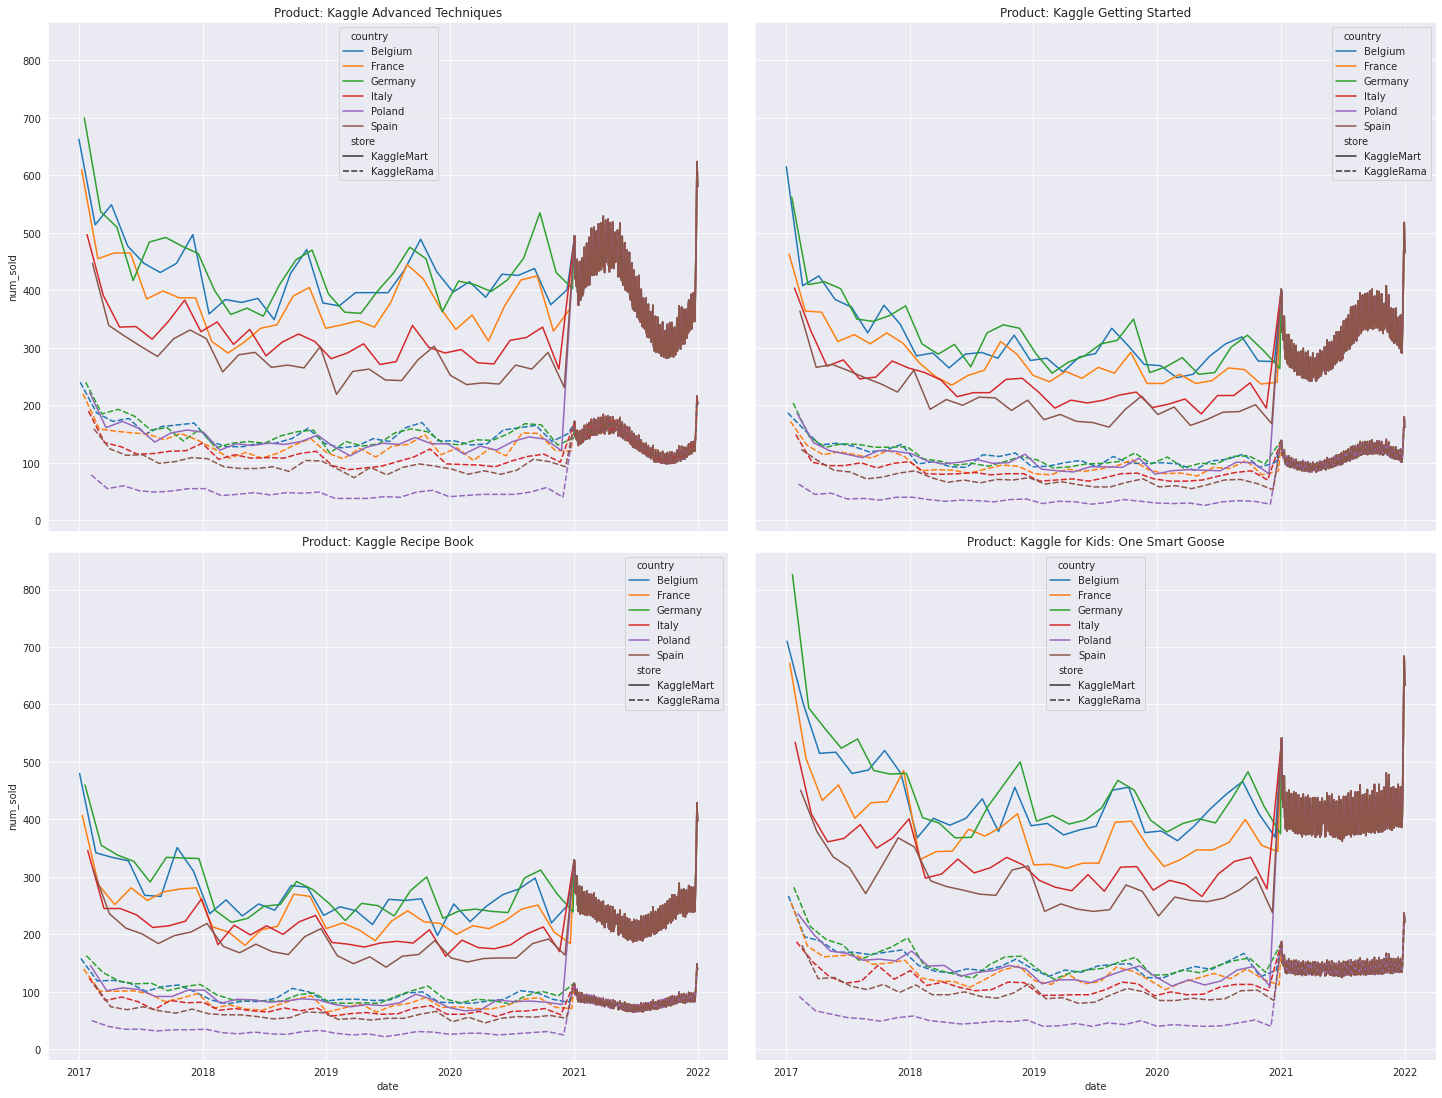

In [101]:
plot_all(pd.concat([tmp1, tmp2]).reset_index(drop=True))

# Submission

In [102]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

row_id  num_sold
0       70128       100
1       70129       100
2       70130       100
3       70131       100
4       70132       100
...       ...       ...
17515   87643       100
17516   87644       100
17517   87645       100
17518   87646       100
17519   87647       100

[17520 rows x 2 columns]

In [103]:
submission['num_sold'] = final_df['num_sold']

In [104]:
submission

row_id  num_sold
0       70128     488.0
1       70129     402.0
2       70130     330.0
3       70131     532.0
4       70132     169.0
...       ...       ...
17515   87643     633.0
17516   87644     201.0
17517   87645     161.0
17518   87646     138.0
17519   87647     219.0

[17520 rows x 2 columns]

In [105]:
# 예측 결과 csv 파일로 저장
submission.to_csv('./predictions/final_prediction.csv', index=False)

# END